
# Data Cleaning

## Objectives

The purpose of this notebook is to **clean, standardize, and prepare the collected datasets** for subsequent exploratory analysis and modeling tasks.

The goal is to transform raw inputs from multiple book datasets into a **reliable, consistent, and mergeable analytical base**, ensuring data integrity and comparability across platforms.

---

## Inputs

| Dataset                    | Source                     | Description                                                               | Format |
| -------------------------- | -------------------------- | ------------------------------------------------------------------------- | ------ |
| `bbe_books.csv`            | Zenodo – *Best Books Ever* | Book metadata including title, author, rating, genres, and description.   | CSV    |
| `books.csv`, `ratings.csv` | GitHub – *Goodbooks-10k*   | Book metadata and user–book interaction data for recommendation modeling. | CSV    |

---

## Tasks in This Notebook

This notebook will execute the following cleaning and preparation steps:

1. **Standardize column formats:**
   Ensure consistent data types and naming conventions across datasets (e.g., convert `isbn` to string, align `author`, `rating`, and `title` formats).

2. **Clean and normalize missing values:**
   Replace placeholder NaNs (`9999999999999`, empty lists, or `"None"`) with `np.nan`, then impute or drop based on analytical importance.

3. **Detect and resolve duplicates:**
   Identify duplicate records using key identifiers (`bookId`, `isbn`, `title + author`) and retain the most complete or relevant entries.

4. **Validate and align categorical values:**
   Standardize genre labels, language codes, and rating scales to ensure comparability between datasets.

5. **Merge compatible datasets:**
   Integrate *BestBooksEver* and *Goodbooks-10k_books* into a unified schema while maintaining referential integrity with the ratings dataset.

6. **Outlier and consistency checks:**
   Review numerical and date fields (e.g., `pages`, `price`, `publishDate`) for unrealistic or extreme values and adjust as needed.

7. **Feature enrichment (optional):**
   Derive or enhance fields such as `popularity_score`, `recency`, or missing genre information using external APIs where beneficial.

---

## Outputs

* **Cleaned, schema-aligned datasets** ready for exploratory data analysis and modeling.
* **Summary statistics** on completeness, duplicates, and outliers.
* **Processed CSV files** saved for reproducibility in `data/processed/`.

> **Note:** This notebook focuses on the *Data Cleaning and Preparation*. Further feature engineering and model-specific transformations will follow in later notebooks.

---


## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [ ]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [ ]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

## Load and Inspect Books Datasets

In this step, we load the previously collected datasets: **Goodbooks-10k** (books) and **Best Books Ever**. We will inspect their structure one more time before starting any merging or cleaning operations.

In [ ]:
import pandas as pd 

# load datasets
books_raw = pd.read_csv('data/raw/books.csv')
bbe_raw = pd.read_csv('data/raw/bbe_books.csv')

# create copies for cleaning
books_clean = books_raw.copy()
bbe_clean = bbe_raw.copy()

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_bbe_path = Path("data/interim/bbe")
interim_bbe_path.mkdir(parents=True, exist_ok=True)

interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 0

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)
books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim datasets saved successfully in data/interim/ directory.")

In [ ]:
# Preview data
display(bbe_clean.head(3))
display(books_clean.head(3))

# Check shape and missing values
for name, df in {'BBE': bbe_clean, 'Books': books_clean,}.items():
    print(f"\n{name} — Shape: {df.shape}")
    print(df.info())
    print(df.isna().sum().sort_values(ascending=False).head())

We will check if the datasets share common identifiers and compatible data types.

In [ ]:
bbe_only_columns = set(bbe_clean.columns) - set(books_clean.columns)
print(f'Columns only in BBE: {bbe_only_columns}')

goodbooks_only_columns = set(books_clean.columns) - set(bbe_clean.columns)
print(f'Columns only in Goodbooks: {goodbooks_only_columns}')

Based on the initial inspection, we can create a mapping table to align columns from both datasets for merging and analysis.

| **BestBooksEver (BBE)** | **Goodbooks10k_books (GB10k)** | **Notes / Alignment Rationale** |
| --------------------------------- | ------------------------------------------------ | -------------------------------------------------------------------------- |
| `bookId` | `book_id` | Main identifier; ensure both are numeric. |
| `bookId_num` | `goodreads_book_id` | Goodreads identifier; ensure both are numeric for joining. |
| `title` | `title` | Direct match. Used as secondary join key. |
| `series` | — | Only in BBE; could enrich GB10k if available via API. |
| `author` | `authors` | Same meaning. Normalize format. |
| `rating` | `average_rating` | Equivalent — rename to unified `average_rating`. |
| `numRatings` | `ratings_count` | Same measure of total user ratings. |
| `ratingsByStars` | `ratings_1` … `ratings_5` | BBE has dict, GB10k has explicit columns. Expand or aggregate accordingly. |
| `likedPercent` | — | BBE-only; optional metric of user sentiment. |
| `isbn` | `isbn` / `isbn13` | Common linking key; keep both (string). Use for merges when present. |
| `language` | `language_code` | Standardize to ISO 639-1 (lowercase). |
| `description` | — | BBE-only; valuable for NLP features. |
| `genres` | — | BBE-only; can enrich GB10k tags later. |
| `characters` | — | BBE-only; low modeling priority, but could add narrative metadata. |
| `bookFormat` | — | BBE-only; possible categorical feature. |
| `edition` | — | BBE-only; low modeling priority. |
| `pages` | — | BBE-only; numeric, may enrich GB10k metadata. |
| `publisher` | — | BBE-only; possible future feature. |
| `publishDate` | — | BBE-only; can approximate from GB10k’s `original_publication_year`. |
| `firstPublishDate` | `original_publication_year` | Equivalent (date vs year). |
| `coverImg` | `image_url` / `small_image_url` | Same function (cover link), to be dropped. |
| `bbeScore` | — | BBE-only; internal popularity score. |
| `bbeVotes` | `work_ratings_count` | Comparable as popularity proxy. |
| `price` | — | BBE-only; likely non-essential for satisfaction prediction. |
| `setting` | — | BBE-only; can support content enrichment. |
| `awards` | — | BBE-only; categorical enrichment. |
| — | `best_book_id` / `work_id` | GB10k-only identifiers; may be used for deeper Goodreads linking. |
| — | `books_count` | GB10k-only; number of editions per work. |
| — | `work_text_reviews_count` | GB10k-only; can complement `numRatings` as engagement metric. |

## Data Cleaning Steps

### Best Books Ever

- Handle identifier columns
- Standardize key columns: `author`, `language`
- Missing data handling strategies
- Normalize genre and format
- Validate for no nulls or duplicates

#### **bookId / bookId_num**

As part of the **Data Collection** phase, we extracted numeric identifiers from the `bookId` field in the **Best Books Ever (BBE)** dataset to create a new column, `bookId_num`, ensuring full compatibility with the `goodreads_book_id` field from the **Goodbooks-10k** dataset. Both columns were standardized to numeric types and validated for completeness and cross-dataset alignment, enabling accurate merging and identifier matching in subsequent analyses.

In this **Data Preparation** stage, we revalidated the identifier field to confirm data integrity. The following checks were performed:

* **Completeness:** No missing (`NaN`) values were found.
* **Uniqueness:** Only **54 duplicates** out of **52,478 records** (0.1%) were detected, likely due to multi-edition entries or duplicate titles referencing the same Goodreads ID.
* **Data type:** All values are stored as `float64` and represent valid numeric identifiers.
* **Range validation:** IDs span from **1** to **55,726,130**, consistent with Goodreads’ typical numeric ID structure.

These verifications confirm that the identifier cleaning from the Data Collection phase remains consistent and reliable. No further transformation is required at this stage.

In [ ]:
# Verify existing identifier cleaning
print("Missing values:", bbe_clean['bookId_num'].isna().sum())
print("Duplicates:", bbe_clean['bookId_num'].duplicated().sum())
print("Unique IDs:", bbe_clean['bookId_num'].nunique())
bbe_clean['bookId_num'].info()

In [ ]:
bbe_clean['bookId_num'].describe().round(2)

In [ ]:
bbe_clean[['title','bookId_num']].sample(10)

The small number of duplicate bookId_num entries reflects legitimate cases where multiple editions or formats (e.g., paperback, e-book, reprint) share the same Goodreads identifier. Since each edition may still hold unique descriptive attributes (e.g., different page counts or publishers), these entries will be retained for now.

In [ ]:
# Check how many of the duplicate rows are fully identical across key metadata fields
key_fields = ['bookId_num', 'title', 'author', 'language', 'bookFormat', 'isbn', 'publishDate', 'firstPublishDate']

# Create a mask for perfect duplicates
exact_dupes_mask = bbe_clean.duplicated(subset=key_fields, keep=False)

# Filter and view them
exact_dupes = bbe_clean[exact_dupes_mask].sort_values(by='bookId_num')

print(f"Exact duplicates found: {exact_dupes.shape[0]}")
print(f"Unique duplicated IDs (fully identical records): {exact_dupes['bookId_num'].nunique()}")

# Preview a few to verify
exact_dupes.head(10)

After inspecting the duplicate `bookId_num` entries, we confirmed that a small subset of rows were fully identical across all key metadata fields (title, author, language, format, ISBN, and publish date). These represented true redundancies rather than alternate editions. To preserve dataset integrity and avoid bias in downstream analyses, we removed these exact duplicates while retaining one instance per unique record.

In [ ]:
bbe_clean = bbe_clean.drop_duplicates(subset=key_fields, keep='first').reset_index(drop=True)
print("Remaining records after removing exact duplicates:", len(bbe_clean))

In [ ]:
# add to drop columns
drop_bbe_cols = ['bookId']

#### **Author**

We will proceed with the standardization of key columns, starting with the `author` column. The author column in the BBE dataset often contains a qualifier such as "(Goodreads Author)". We will remove such qualifiers to standardize the format. We will also create an additional list column to store multiple authors as a list rather than a single string. This way, its is ready to use for feature engineering later on if needed.

In [ ]:
import re
import pandas as pd

def clean_and_split_authors(name):
    """
    Cleans author names and returns a list of authors.
    """
    if pd.isna(name):
        return None

    # Remove role descriptors
    cleaned = re.sub(r"\s*\([^)]*\)", "", name)
    
    # split on commas and lowercase each name
    authors_list = [a.strip().lower() for a in cleaned.split(",") if a.strip()]
        
    return authors_list

In [ ]:
# Apply to BestBooksEver dataset
bbe_clean["authors_list"] = bbe_clean["author"].apply(clean_and_split_authors)
bbe_clean["author_clean"] = bbe_clean["authors_list"].apply(lambda x: ", ".join(x) if isinstance(x, list) else None)

# Quick check
bbe_clean[["author", "author_clean", "authors_list"]].head(5)

In [ ]:
# add drop column
drop_bbe_cols.append('author')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 1

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim author datasets saved successfully in data/interim/ directory.")

#### **Language**

The `language` column in the Best Books Ever dataset used full names such as “English”, “German”, and “Arabic”.  Before transforming the values, we will check for all unique values to identify any unexpected entries.

In [ ]:
# Inspect unique language values
print("Unique language values in BBE dataset:")
bbe_clean['language'] = bbe_clean['language'].astype(str).str.strip()
unique_languages = bbe_clean['language'].unique()

print(f"\nTotal unique values: {len(unique_languages)}\n")
print(unique_languages)

We can see that there are some unexpected values such as:
- _historical forms_ (“English, Middle (1100-1500)”, “French, Middle (ca.1400-1600)”)
- _combined or semicolon-separated entries_ (“Filipino; Pilipino”, “Catalan; Valencian”)
- _multi-language / uncertain cases_ (“Multiple languages”, “Undetermined”)
- _rare or dialects_ (“Bokmål, Norwegian; Norwegian Bokmål”, “Aromanian; Arumanian; Macedo-Romanian”)

We will clean the unusual entries by mapping them to the closest language present in the ISO 639-1 standard. Unrecognized values will be flagged and replaced with `"unknown"`. It was decided to distinguish the `"unknown"` from the `NaN` values to retain information about missingness versus unrecognized entries. 

In [ ]:
import numpy as np

# Standardize capitalization & spacing
bbe_clean['language'] = bbe_clean['language'].astype(str).str.strip().str.title()

# Handle NaNs that became strings
bbe_clean['language'] = bbe_clean['language'].replace({'Nan': np.nan})

# Simplify and unify multi-language / dialect forms
replace_map = {
    'Multiple Languages': 'Multilingual',
    'Undetermined': 'Unknown',
    'Iranian (Other)': 'Persian',
    'Farsi': 'Persian',
    'Filipino; Pilipino': 'Filipino',
    'Catalan; Valencian': 'Catalan',
    'Panjabi; Punjabi': 'Punjabi',
    'Bokmål, Norwegian; Norwegian Bokmål': 'Norwegian',
    'Norwegian Nynorsk; Nynorsk, Norwegian': 'Norwegian',
    'Greek, Modern (1453-)': 'Greek',
    'Greek, Ancient (To 1453)': 'Greek',
    'French, Middle (Ca.1400-1600)': 'French',
    'English, Middle (1100-1500)': 'English',
    'Dutch, Middle (Ca.1050-1350)': 'Dutch',
    'Aromanian; Arumanian; Macedo-Romanian': 'Romanian',
    'Mayan Languages': 'Mayan',
    'Australian Languages': 'English'
}

bbe_clean['language'] = bbe_clean['language'].replace(replace_map)

After transforming the values, we apply a mapping to standardize the `language` column using **ISO 639-1 two-letter codes**.
The mapping dictionaries are stored in the `src/cleaning/mappings/` folder to keep the notebooks cleaner and improve readability.

In [ ]:
import json

with open("src/cleaning/mappings/languages_dict.json", "r", encoding="utf-8") as f:
    languages_dict = json.load(f)

# Apply dictionary
bbe_clean['language_clean'] = bbe_clean['language'].str.lower().map(languages_dict)

# Fill remaining NaNs
bbe_clean['language_clean'] = bbe_clean['language_clean'].fillna('unknown')

In [ ]:
# check again for unique language values
print("Unique language values in BBE dataset:")
unique_languages = bbe_clean['language_clean'].unique()

print(f"\nTotal unique values: {len(unique_languages)}\n")
print(unique_languages)

In [ ]:
language_breakdown = (
    bbe_clean['language_clean']
    .value_counts()
    .to_frame('count')
)

language_breakdown['percentage'] = (
    language_breakdown['count'] / len(bbe_clean) * 100
).round(2)

print(language_breakdown)

In [ ]:
# add drop column
drop_bbe_cols.append('language')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 2

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim language datasets saved successfully in data/interim/ directory.")

#### **Dates**

BBE dataset has two publication fields: `publishDate` and `firstPublishDate`. The `firstPublishDate` represents the original publication date, while `publishDate` refers to a more recent edition or reprint date. Publishing experts assumption is that the recency of the `firstPublishDate` is more relevant for modeling book satisfaction, as it reflects when the book was first introduced to readers. Therefore, we will focus on cleaning and standardizing the `firstPublishDate` column and use `publishDate` only if `firstPublishDate` is missing.

While majority of the dates follow the 'MM/DD/YY' format, after a first attemp at cleaning, we noticed some dates do not conform to this format. Therefore, we will implement a more robust date parsing strategy, focusing first on transforming textual formats into 'MM/DD/YYYY' format before attempting to parse them into datetime objects.

In [ ]:
from dateutil import parser

def clean_date_string(date_str):
    """Remove ordinal suffixes and unwanted characters from a date string."""
    if pd.isna(date_str):
        return np.nan
    # remove st, nd, rd, th (like 'April 27th 2010' → 'April 27 2010')
    cleaned = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', str(date_str))
    return cleaned.strip()

def parse_mixed_date(date_str):
    """Try to parse a variety of date formats safely."""
    if pd.isna(date_str) or date_str == '':
        return np.nan
    try:
        # Use dateutil to parse most human-readable formats
        return parser.parse(date_str, fuzzy=True)
    except Exception:
        # Try year-only fallback (e.g. '2003')
        match = re.match(r'^\d{4}$', str(date_str))
        if match:
            return pd.to_datetime(f"{date_str}-01-01")
        return np.nan

In [ ]:
# Apply cleaning to both columns
for col in ['firstPublishDate', 'publishDate']:
       bbe_clean[f'{col}_clean'] = (
        bbe_clean[col]
        .astype(str)
        .replace({'nan': np.nan, '': np.nan})
        .apply(clean_date_string)
        .apply(parse_mixed_date)
    )

In [ ]:
# Combine using your logic: prefer firstPublishDate, else publishDate
bbe_clean['publication_date_clean'] = (
    bbe_clean['firstPublishDate_clean'].combine_first(bbe_clean['publishDate_clean'])
)
# Reconvert to datetime safely before using .dt
bbe_clean['publication_date_clean'] = pd.to_datetime(bbe_clean['publication_date_clean'], errors='coerce')

# Format as ISO standard
bbe_clean['publication_date_clean'] = bbe_clean['publication_date_clean'].dt.strftime("%Y-%m-%d")

# Check a sample of remaining nulls
bbe_clean[bbe_clean['publication_date_clean'].isna()][['title', 'firstPublishDate', 'publishDate', 'publication_date_clean']].head(10)

In [ ]:
# Filter rows where the unified publication date is missing
total = len(bbe_clean)
bbe_missing_dates = bbe_clean.loc[bbe_clean['publication_date_clean'].isna()]
missing_count = len(bbe_missing_dates)

print(f"Missing publication dates: {missing_count} of {total} ({missing_count/total:.2%})")

# Preview key columns
bbe_missing_dates[['title', 'author_clean', 'firstPublishDate', 'publishDate', 'publication_date_clean']].head(10)

In [ ]:
# add drop column
drop_bbe_cols.extend(['firstPublishDate', 'publishDate', 'firstPublishDate_clean', 'publishDate_clean'])

In [ ]:
from pathlib import Path

version = 3

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim dates datasets saved successfully in data/interim/ directory.")

#### **Publisher**

Publisher names can vary significantly in formatting, including differences in capitalization, punctuation, and spacing. To standardize the `publisher` column, we will convert all entries to lowercase and strip any leading or trailing whitespace. This will help reduce variability and improve consistency across the dataset.

In [ ]:
print("Sample publishers:")
print(bbe_clean['publisher'].drop_duplicates().sample(30, random_state=42).values)

In [ ]:

# Strip, lowercase, remove extra spaces and punctuation
bbe_clean['publisher'] = (
    bbe_clean['publisher']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
    .str.replace(r'[.,]', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
)

In [ ]:
# Inspect unique publisher values 
bbe_clean['publisher'] = bbe_clean['publisher'].astype(str).str.strip() 
unique_publisher = bbe_clean['publisher'].unique() 

print(f"\nTotal unique publisher values: {len(unique_publisher)}\n") 

In [ ]:
# normalize numeric publishers names:
def clean_numeric_publishers(x):
    if re.match(r'^\d+$', x.strip()):
        return 'unknown'
    return x

bbe_clean['publisher'] = bbe_clean['publisher'].apply(clean_numeric_publishers)

This cleaning step reduced the number of unique publisher names from **11,111 to 10,764**.
Since **English-language books represent 81% of the catalogue**, the analysis will focus on this segment.
We will **standardize major English-language publishing groups**, consolidating their **imprints and subsidiaries**, and apply **fuzzy matching** to unify names with **minor variations**.

In [ ]:
# load publishers dictionary
with open("src/cleaning/mappings/publishers_dict.json", "r", encoding="utf-8") as f:
    publishers_dict = json.load(f)

In [ ]:
from rapidfuzz import process, fuzz

# Get top 10000 most common publishers
top_n = 10000
publisher_counts = bbe_clean['publisher'].value_counts()
top_publishers = publisher_counts.head(top_n).index.tolist()

# Create a mapping for top publishers only
standardization_map = {}
processed = set()

for pub in top_publishers:
    if pub in processed:
        continue
    
    # Find similar publishers in the top list
    matches = process.extract(pub, top_publishers, scorer=fuzz.ratio, limit=5)
    
    # Group similar ones (score > 90)
    similar = [m[0] for m in matches if m[1] > 90]
    canonical = similar[0]  # Use first as canonical
    
    for similar_pub in similar:
        standardization_map[similar_pub] = canonical
        processed.add(similar_pub)

# Apply the mapping
bbe_clean['publisher_standardized'] = bbe_clean['publisher'].replace(standardization_map)

# Then apply manual mapping
bbe_clean['publisher_standardized'] = bbe_clean['publisher_standardized'].replace(publishers_dict)

In [ ]:
standardized_unique_publisher = bbe_clean['publisher_standardized'].unique() 

print(f"\nTotal unique publisher values: {len(standardized_unique_publisher)}\n") 

print("Sample publishers:")
print(bbe_clean['publisher_standardized'].drop_duplicates().sample(30, random_state=42).values)

The cleaning process reduced the number of unique publisher names from **11,111 to 9993**, representing a **10% decrease**.
Given that the dataset includes books in multiple languages and many small or independent publishers, this reduction is a **satisfactory outcome**.

To further evaluate the effectiveness of the cleaning, we will analyze the **proportion of titles associated with the most common publishers**.
This will help us assess how well the standardization process **consolidated the publisher catalog** and captured the main publishing groups.

In [ ]:
# core publisher groups
major_publishers = [
    'penguin random house', 'harpercollins', 'macmillan',
    'simon & schuster', 'hachette', 'bloomsbury',
    'amazon publishing', 'scholastic'
]

# Create a flag
bbe_clean['is_major_publisher'] = bbe_clean['publisher_standardized'].isin(major_publishers)

# Count results
total_books = len(bbe_clean)
major_books = bbe_clean['is_major_publisher'].sum()
share_major = major_books / total_books * 100

print(f"Books from mapped major publishers: {major_books} of {total_books} ({share_major:.2f}%)")


About 17% of all titles now belong to one of the standardized major publisher groups.
The remaining publishers represent independent, regional, or self-published works.
Further improvements (e.g., mapping academic and international publishers) could expand this coverage to 25–30%. But we'll leave it as is for now.

In [ ]:
# add drop column
drop_bbe_cols.append('publisher')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 4

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim publisher datasets saved successfully in data/interim/ directory.")

#### **Book Format**

This step standardizes the `bookFormat` field across multiple languages and inconsistent label variations found in the dataset.  
The goal is to translate all format names into English and consolidate equivalent values (e.g., *“Capa dura”*, *“Gebundene Ausgabe”*, *“Hard back”*) under unified categories such as **Hardcover**, **Paperback**, **Ebook**, and **Audiobook**.

This cleaning ensures that:
- Format values are consistent for analysis and visualization.  
- Non-English or rare variants are translated and grouped appropriately.  
- Missing or unrecognized entries are handled under a neutral category: **Other / Unknown**.  

By applying a mapping dictionary, we make the variable suitable for aggregation, comparison, and predictive modeling. After transformation, we verify the result by inspecting the number of unique standardized values.


In [ ]:
# Inspect unique format values 
bbe_clean['bookFormat'] = bbe_clean['bookFormat'].astype(str).str.strip() 
unique_format = bbe_clean['bookFormat'].unique() 

print(f"\nTotal unique book format values: {len(unique_format)}\n") 

In [ ]:
print(unique_format)

In [ ]:
# load format dictionary
with open("src/cleaning/mappings/format_dict.json", "r", encoding="utf-8") as f:
    format_dict = json.load(f)

In [ ]:
bbe_clean['bookFormat_clean'] = (
    bbe_clean['bookFormat']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace(format_dict)
)

# Replace remaining unknowns or NaN with a unified label
bbe_clean['bookFormat_clean'] = bbe_clean['bookFormat_clean'].replace(['nan', 'none', ''], np.nan)
bbe_clean['bookFormat_clean'] = bbe_clean['bookFormat_clean'].fillna('Other / Unknown')

In [ ]:
unique_format_clean = bbe_clean['bookFormat_clean'].unique() 

print(f"\nTotal unique book format values: {len(unique_format_clean)}\n") 

In [ ]:
unique_format_clean

In [ ]:
# add drop column
drop_bbe_cols.append('bookFormat')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 5

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim format datasets saved successfully in data/interim/ directory.")

After applying the standardization mapping, the number of unique book format values was reduced from **135** to **10**.  This represents a substantial improvement in data consistency and interpretability.  

#### **ISBN and ASIN Cleaning**

The BBE dataset includes a single `isbn` column, which initially contained numerous missing or invalid entries (e.g. placeholder values such as `9999999999999`).

Our initial cleaning flow focused solely on standardizing **ISBN** values, but upon further inspection, we identified additional patterns such as **Amazon ASINs** (10-character alphanumeric codes) and prefixed identifiers like `10:` or `13:`.

These findings led to an adjustment to the cleaning logic and the order of operations in the pipeline.

The final cleaning process:

- Removes punctuation and non-digit characters to standardize ISBN formatting.
- Detects and separates ASINs (`asin` column) to preserve them for potential cross-dataset enrichment.
- Handles prefixed identifiers (e.g., `13:9780615700`) by removing prefixes before validation.
- Filters out placeholder or invalid entries (`999…`, `000…`) and ensures consistent string representation.
- Creates a new `isbn_clean` column containing only valid ISBN-10 or ISBN-13 values.

In [ ]:
# Inspect ISBN column
bbe_clean[['title','isbn']].head(10)

In [ ]:
# Check missing and invalid patterns
n_missing_isbn = bbe_clean['isbn'].isna().sum()
print(f'Number of missing ISBN entries: {n_missing_isbn}')

In [ ]:
# Identify invalid placeholders (like 9999999999999)
n_invalid_isbn = bbe_clean[bbe_clean['isbn'].astype(str).str.contains('9999999999')].shape[0]
print(f'Number of placeholder ISBN entries: {n_invalid_isbn}')

In [ ]:
def detect_asin(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    if re.fullmatch(r'[A-Z0-9]{10}', x) and not x.isdigit():  # must have at least one letter
        return x
    return np.nan

In [ ]:
bbe_clean['asin'] = bbe_clean['isbn'].apply(detect_asin)
has_asin = bbe_clean[bbe_clean['asin'].notna()] 
print(f'Books with ASINs: {len(has_asin)}')
has_asin[['title','isbn', 'asin']].head(10)

In [ ]:
def clean_isbn(x):
    # handle missing
    if pd.isna(x):
        return np.nan

    # detect ASIN first
    asin_val = detect_asin(x)
    if pd.notna(asin_val):
        # return NaN for ISBN cleaning, because it's an ASIN
        return np.nan  

    # clean numeric ISBNs
    s = str(x).strip()
    s = re.sub(r'^(10:|13:)', '', s)       # remove leading prefixes
    s = re.sub(r'\D', '', s)               # keep only digits

    # handle placeholders
    if re.fullmatch(r'(9{10}|9{13}|0{10}|0{13})', s):
        return np.nan

    # keep valid ISBN-10 or ISBN-13
    if len(s) in [10, 13]:
        return s

    return np.nan

In [ ]:
bbe_clean['isbn_clean'] = bbe_clean['isbn'].apply(clean_isbn)

In [ ]:
# Inspect ISBN columns after cleaning
bbe_clean[['title','isbn', 'isbn_clean']].head(10)

In [ ]:
placeholder_remaining = bbe_clean[bbe_clean['isbn_clean'].astype(str).str.fullmatch(r'(9{10}|9{13}|0{10}|0{13})', na=False)]
print(f"Remaining placeholder ISBNs: {len(placeholder_remaining)}")

In [ ]:
# Filter the rows where isbn_clean is NaN
missing_isbn_clean = bbe_clean[bbe_clean['isbn_clean'].isna()]

# Print the number of missing and show the first few examples
print(f"Missing isbn_clean: {missing_isbn_clean.shape[0]}")
missing_isbn_clean[['title', 'bookFormat_clean', 'isbn', 'asin','isbn_clean']].head(10)

To inspect if there are other cases of invalid ISBNs, we will filter the rows where the `isbn_type` is either `'wrong_length'` or `'missing'`. This will help us identify any additional issues with the ISBN data that may need to be addressed. For that a custom function `isbn_type` was created to classify the reason for invalidity.

In [ ]:
def isbn_type(x):
    if pd.isna(x):
        return 'missing'

    s = str(x).strip()

    # Detect ASIN (10-char alphanumeric, must have at least one letter)
    if re.fullmatch(r'[A-Z0-9]{10}', s.upper()) and not s.isdigit():
        return 'asin'

    # Remove non-digits for numeric checks
    x = re.sub(r'\D', '', s)

    # Placeholder patterns
    if re.fullmatch(r'9{10}|9{13}', x):
        return 'placeholder_9'
    if re.fullmatch(r'0{10}|0{13}', x):
        return 'placeholder_0'

    # Length checks
    if len(x) in [10, 13]:
        return 'valid'
    if len(x) > 0:
        return 'wrong_length'

    return 'missing'

In [ ]:
bbe_clean['isbn_type'] = bbe_clean['isbn'].apply(isbn_type)
bbe_clean['isbn_type'].value_counts()

The `isbn_type` function accurately distinguished valid ISBNs, ASINs, and placeholders and can be used to validate the data cleaning pipeline.

In [ ]:
bbe_clean['isbn_type'] = bbe_clean['isbn_clean'].apply(isbn_type)
bbe_clean['isbn_type'].value_counts()

In [ ]:
# Filter rows with type either 'wrong_length' or 'missing'
invalid_isbn = bbe_clean[bbe_clean['isbn_type'].isin(['missing'])]

# Show total count
print(f"Total invalid (missing): {invalid_isbn.shape[0]}")

# Preview relevant columns
invalid_isbn[['title', 'author_clean', 'bookFormat_clean', 'isbn', 'asin', 'isbn_type']].head(10)

Out of all records, **9,078 entries (≈18%)** were identified as invalid ISBNs, leaving roughly **82%** valid.
Invalid cases, after cleaning are limited to the `'missing'` type.

In [ ]:
# add drop column
drop_bbe_cols.extend(['isbn', 'isbn_type'])
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 6

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim ISBN/ASIN datasets saved successfully in data/interim/ directory.")

#### **Ratings**

In this step, we will first evaluate the quality and consistency of the `rating` field.
We first check for missing or invalid values and calculate the percentage of available ratings to assess data completeness. Then, we use the `describe()` method to verify whether the ratings follow the expected 1–5 scale.

In [ ]:
# Filter the rows where rating is not NaN
total_books = len(bbe_clean)
has_ratings = bbe_clean[bbe_clean['rating'].notna()]
has_ratings_num = has_ratings.shape[0]
share_ratings = has_ratings_num / total_books * 100

# Print the number of titles with ratings and show the first few examples
print(f"Books with ratings: {has_ratings_num} of {total_books} ({share_ratings:.2f}%)")
has_ratings[['title', 'rating', 'numRatings','ratingsByStars']].head(10)

In [ ]:
bbe_clean['rating'].describe().round(2)

In [ ]:
bbe_clean['rating'].unique()[:20]

The inspection confirms that the dataset is generally clean; however, a small number of entries have a value of `0`, which represents missing evaluations. These will be replaced with `NaN` to ensure the ratings remain within the valid range (1–5). Since all valid values already follow the standard Goodreads scale, no normalization is required.

In [ ]:
mask = (bbe_clean['rating'] == 0)
print(f'Items with value equal 0: {bbe_clean[mask].shape[0]}')
bbe_clean[mask][['title', 'author_clean','rating','numRatings','ratingsByStars']].head()

In [ ]:
bbe_clean['rating_clean'] = bbe_clean['rating'].replace(0, np.nan)

In [ ]:
bbe_clean['rating_clean'].describe().round(2)

In [ ]:
import matplotlib.pyplot as plt

bbe_clean['rating_clean'].hist(bins=20)
plt.title('Distribution of Average Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### **NumRating**

Next we will handle `numRatings`. The `numRatings` feature represents the total count of user ratings per book. We seen know from the mask we created that where `ratings` equals `0`, `numRatings` tends to be `0` too. We will check if that is always the case by checking for invalid values and using the `.describe()` method.

In [ ]:
na_numRatings = bbe_clean[bbe_clean['numRatings'].isna()]
na_numRatings_num = na_numRatings.shape[0]
share_numRatings = na_numRatings_num / total_books * 100

# Print the number of titles with ratings and show the first few examples
print(f"Books with no numRatings values: {na_numRatings_num} of {total_books} ({share_numRatings}%)")

In [ ]:
bbe_clean['numRatings'].describe().round(2)

Since it’s a valid count metric (0 values indicate unrated books), no replacement with NaN is required. However, because most books have relatively few ratings while a few very popular titles have millions, the distribution is heavily right-skewed. To better visualize and later analyze relationships with other variables, we apply a logarithmic transformation (`log1p`) to smooth out the long tail and reveal underlying patterns.

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.log1p(bbe_clean['numRatings']), bins=50)
plt.title("Distribution of Log(Number of Ratings)")
plt.show()

The log transformation reveals a near-normal distribution centered around books with moderate popularity.
This confirms that `numRatings` is a valid and informative feature, and no normalization or imputation is needed at this stage.

In [ ]:
# Log-transform the count to reduce skew
bbe_clean['numRatings_log'] = np.log1p(bbe_clean['numRatings'])

#### **ratingsByStars**

In this step, we examine how complete the `ratingsByStars` field is across all books.  
This feature represents the 1–5 star breakdown of user ratings and is essential for modelling engagement quality and satisfaction patterns.

In [ ]:
na_ratings_stars = bbe_clean[bbe_clean['ratingsByStars'].isna()]
na_ratings_stars_num = na_ratings_stars.shape[0]
share_na_ratings_stars = na_ratings_stars_num / total_books * 100

# Print the number of titles with ratingsByStars and show the first few examples
print(f"Books with ratingsByStars: {na_ratings_stars_num} of {total_books} ({share_na_ratings_stars}%)")

In [ ]:
bbe_clean['ratingsByStars'].describe()

In [ ]:
empty_ratings_stars_mask = (bbe_clean['ratingsByStars'] == '[]')
empty_ratings_stars = bbe_clean[empty_ratings_stars_mask].shape[0]
print(f'Items with empty values: {empty_ratings_stars}')
bbe_clean[empty_ratings_stars_mask][['title', 'author_clean','rating','numRatings','ratingsByStars']].head(10)

By quantifying missing or empty values, we identify potential inconsistencies between overall ratings (`rating`, `numRatings`) and their detailed distribution.
After counting missing and empty entries, we compare these against books that *do* have `rating` and `numRatings` values.  

In [ ]:
# mask for books with ratings
mask_has_ratings = (bbe_clean['numRatings'] > 0) & (bbe_clean['rating'] > 0)
# mask for books without rating distributions
mask_no_distribution = (bbe_clean['ratingsByStars'] == '[]')
# combine masks: have ratings but no distribution:
mask_rated_no_distribution = mask_has_ratings & mask_no_distribution

In [ ]:
# Count and inspect missing star distributions among rated books

# count how many books have ratings but no ratingsByStars distribution
num_missing_dist = mask_rated_no_distribution.sum()
share_missing_dist = num_missing_dist / len(bbe_clean) * 100

# count total books with empty or missing distributions (regardless of ratings)
total_empty_dist = empty_ratings_stars_mask.sum()

# compute what share of those empty distributions actually have valid ratings
share_with_ratings = (num_missing_dist / total_empty_dist) * 100
share_without_ratings = 100 - share_with_ratings

# print results
print(f"Total books: {len(bbe_clean):,}")
print(f"Books with ratings but missing distribution: {num_missing_dist:,} ({share_missing_dist:.2f}%)")
print(f"  ↳ Of all empty distributions ({total_empty_dist:,} total):")
print(f"      • With ratings: {share_with_ratings:.2f}%")
print(f"      • Without ratings: {share_without_ratings:.2f}%")

# inspect a few examples
bbe_clean.loc[mask_rated_no_distribution, ['title', 'author_clean', 'rating', 'numRatings', 'ratingsByStars']].head(10)


This highlights a critical gap: books with ratings but without a distribution breakdown.  

Such gaps likely stem from export limitations or missing historical data from Goodreads, and must be addressed before feature engineering or predictive tasks.

To handle missing `ratingsByStars` while preserving analytical completeness, we implement a probabilistic estimation function.  
The approach assumes a normal distribution around the book’s average rating, proportionally allocating counts across 1–5 stars.  

This preserves both the **total number of ratings** and the **shape of expected user sentiment**, ensuring downstream models can use these reconstructed values.

In [ ]:
import numpy as np
import pandas as pd

def estimate_star_distribution(avg_rating, num_ratings):
    # define 1–5 star levels
    stars = np.arange(1, 6)

    # normal distribution around avg_rating
    # - (stars - avg_rating): distance of each star value from the mean
    # - **2: squares the distance to emphasize larger deviations
    # - -0.5 * (...): converts distance into a negative exponent (closer = less negative)
    # - np.exp(...): applies exponential decay, giving higher weights to values near the mean
    # - 0.5 controls the curve’s spread (smaller = narrower, larger = wider)
    weights = np.exp(-0.5 * ((stars - avg_rating) ** 2) / 0.5**2)
    weights /= weights.sum()  # normalize to 1
    
    # Scale to total ratings
    estimated_counts = np.round(weights * num_ratings).astype(int)

    # Adjust rounding error so sum matches exactly
    diff = num_ratings - estimated_counts.sum()
    estimated_counts[np.argmax(weights)] += diff

    return estimated_counts.tolist()

# code inspiration: 
# https://www.geeksforgeeks.org/machine-learning/gaussian-distribution-in-machine-learning/
# https://www.geeksforgeeks.org/python/python-normal-distribution-in-statistics/
# https://www.geeksforgeeks.org/numpy/binning-data-in-python-with-scipy-numpy/
# https://blog.quantinsti.com/gaussian-distribution/
# https://www.freecodecamp.org/news/how-to-explain-data-using-gaussian-distribution-and-summary-statistics-with-python/

The function is applied to all titles with valid ratings but missing distributions.  
We then validate that each reconstructed list of star counts sums to its corresponding `numRatings`, ensuring internal consistency.  
A high proportion of valid totals indicates that the imputation strategy worked as intended.

In [ ]:
bbe_clean['ratingsByStars_clean'] = bbe_clean['ratingsByStars']
# For books missing star distributions but with valid ratings,
# estimate a plausible 1–5 star breakdown using avg_rating and numRatings,
# and store the result in 'ratingsByStars_clean'.
bbe_clean.loc[mask_rated_no_distribution, 'ratingsByStars_clean'] = (
    bbe_clean.loc[mask_rated_no_distribution]
    .apply(lambda x: estimate_star_distribution(x['rating'], int(x['numRatings'])), axis=1)
)

In [ ]:
# check how many were filled
filled_count = bbe_clean.loc[mask_rated_no_distribution, 'ratingsByStars_clean'].notna().sum()
print(f"Filled distributions: {filled_count:,} (of {mask_rated_no_distribution.sum():,} missing)")

# preview examples
print("\nSample of estimated distributions:")
display(
    bbe_clean.loc[mask_rated_no_distribution, 
                  ['title', 'author_clean', 'rating', 'numRatings', 'ratingsByStars_clean']
                 ].head(10)
)

In [ ]:
# confirm that each estimated list sums correctly
check_sum = bbe_clean.loc[mask_rated_no_distribution].apply(
    lambda x: sum(x['ratingsByStars_clean']) == int(x['numRatings']), axis=1
)
valid_share = check_sum.mean() * 100
print(f"\nDistributions matching numRatings total: {valid_share:.2f}%")

We extend the validation to the full dataset, verifying that all `ratingsByStars_clean` entries, both original and estimated, correctly sum to `numRatings`. This serves as a final data integrity checkpoint.

In [ ]:
import ast
import numpy as np

def safe_sum_ratings(row):
    val = row['ratingsByStars_clean']
    # Convert stringified lists into Python lists
    if isinstance(val, str):
        try:
            val = ast.literal_eval(val)
        except Exception:
            return np.nan

    # If it's a list, make sure elements are integers
    if isinstance(val, list):
        try:
            val = [int(v) for v in val]  # convert each element to int
            return sum(val) == int(row['numRatings'])
        except Exception:
            return np.nan

    return np.nan

# https://dev.to/mstuttgart/using-literal-eval-for-string-to-object-conversion-in-python-46i
# https://www.educative.io/answers/what-is-astliteralevalnodeorstring-in-python

In [ ]:
check_sum_all = bbe_clean.loc[bbe_clean['ratingsByStars_clean'].notna()].apply(safe_sum_ratings, axis=1)
valid_share_all = check_sum_all.mean() * 100

print(f"All distributions matching numRatings total: {valid_share_all:.2f}%")

Next, we replace remaining `'[]'` values using `np.nan`.

In [ ]:
remaining_empty_ratings_stars_mask = (bbe_clean['ratingsByStars_clean'] == '[]')
remaining_empty_ratings_stars = bbe_clean[remaining_empty_ratings_stars_mask].shape[0]
print(f'Remaining empty values: {remaining_empty_ratings_stars}')

In [ ]:
bbe_clean['ratingsByStars_clean'] = bbe_clean['ratingsByStars_clean'].replace('[]', np.nan)

In [ ]:
bbe_clean['ratingsByStars_clean'].head()

We decided to split the list into individual features as it makes it easier to query and filter, better for statistical operations, it is more intuitive for visualization and standard format for tabular data.

In [ ]:
import ast
import numpy as np
import pandas as pd

def parse_ratings_to_list(val):
    """Parse and return ratings in correct order"""
    
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return [np.nan] * 5
    
    if isinstance(val, list):
        try:
            clean_list = [int(v) for v in val]
            if len(clean_list) == 5:
                # REVERSE the list if it's stored as [5★, 4★, 3★, 2★, 1★]
                return clean_list[::-1]  # This reverses to [1★, 2★, 3★, 4★, 5★]
            else:
                return [np.nan] * 5
        except (ValueError, TypeError):
            return [np.nan] * 5
    
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list) and len(parsed) == 5:
                return [int(v) for v in parsed][::-1]  # Reverse here too
            else:
                return [np.nan] * 5
        except Exception:
            return [np.nan] * 5
    
    return [np.nan] * 5

# apply the function
bbe_clean['ratings_parsed'] = bbe_clean['ratingsByStars_clean'].apply(parse_ratings_to_list)

In [ ]:
# expand into separate columns
ratings_expanded = bbe_clean['ratings_parsed'].apply(pd.Series)
ratings_expanded.columns = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
# add to dataframe
bbe_clean = pd.concat([bbe_clean, ratings_expanded], axis=1)

In [ ]:
# verify
print("\nNew rating columns created:")
print(bbe_clean[['title', 'rating_clean', 'numRatings', 'ratings_1', 'ratings_2', 
                  'ratings_3', 'ratings_4', 'ratings_5']].head(10))

# verify sums match numRatings
bbe_clean['ratings_sum_check'] = bbe_clean[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)
matches = (bbe_clean['ratings_sum_check'] == bbe_clean['numRatings']).sum()
print(f"\nRatings that sum correctly: {matches} / {len(bbe_clean)}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# calculate mean shares for BBE dataset
# first, create share columns if you haven't already
for i in range(1, 6):
    bbe_clean[f'ratings_{i}_share'] = bbe_clean[f'ratings_{i}'] / bbe_clean['numRatings']

# calculate average shares
mean_shares_bbe = [bbe_clean[f"ratings_{i}_share"].mean() for i in range(1, 6)]

# create the bar chart
plt.bar(range(1, 6), mean_shares_bbe)
plt.title("Average Star Rating Distribution (Best Books Ever)")
plt.xlabel("Star Rating")
plt.ylabel("Average Share of Ratings")
plt.show()

Lastly, we computed mean star-share distributions and plotted comparative bar charts to visualize global reader sentiment patterns.
This revealed the datasets follow a similar right-skewed pattern, where 4- and 5-star ratings dominate—typical of user-generated book reviews.

In [ ]:
# add drop column
drop_bbe_cols.extend(['ratingsByStars', 'rating', 'numRatings', 'ratingsByStars_clean', 'ratings_parsed','ratings_sum_check'])
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 7

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim ratings datasets saved successfully in data/interim/ directory.")

#### **Genres**

In memory-based recommender systems, categorical attributes such as genre serve as key features for similarity computation. In this step, we first identify and handle missing values, then parse the genre lists using `ast.literal_eval` to ensure proper data structure representation, and finally quantify the unique genres and analyze their distribution across the dataset.

In [ ]:
# identify and handle missing genre values
empty_genres_mask = (bbe_clean['genres'] == '[]')
empty_genres = bbe_clean[empty_genres_mask].shape[0]
share_missing_genres = (empty_genres / len(bbe_clean)) * 100
print(f'Books with empty genre values: {empty_genres} ({share_missing_genres:.2f}%)')

In [ ]:
import re
import ast
import numpy as np
import pandas as pd

# GENERIC PARSING AND CLEANING FUNCTIONS

def parse_list_field(val):
    """
    Safely parse a stringified list (e.g. '["x", "y"]') into a Python list.
    Returns np.nan for missing, invalid, or empty values.
    """
    if pd.isna(val) or val in ['[]', '', None]:
        return np.nan
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed
        else:
            return np.nan
    except Exception:
        return np.nan


def clean_text_item(text, keep_pattern=r'[^a-z0-9\s-]'):
    """
    Lowercase and remove noise, keeping only letters, digits, hyphens and spaces.
    Can be reused for genres, awards, etc.
    """
    if not isinstance(text, str):
        return ''
    text = text.lower().strip()
    text = re.sub(keep_pattern, '', text)  # clean unwanted chars
    text = re.sub(r'\s+', ' ', text)       # collapse multiple spaces
    return text.strip()


def clean_list_field(lst, keep_pattern=r'[^a-z0-9\s-]'):
    """
    Clean and deduplicate elements from a list of strings.
    Returns np.nan for invalid or empty lists.
    """
    if not isinstance(lst, list):
        return np.nan
    cleaned = [clean_text_item(item, keep_pattern) for item in lst if isinstance(item, str) and item.strip()]
    cleaned = [c for c in cleaned if c]
    return list(set(cleaned)) if cleaned else np.nan


In [ ]:
bbe_clean['genres_parsed'] = bbe_clean['genres'].apply(parse_list_field)

In [ ]:
bbe_clean['genres_parsed'] = bbe_clean['genres_parsed'].apply(clean_list_field)

In [ ]:
# sanity check
print(bbe_clean['genres_parsed'].apply(type).value_counts())
print(bbe_clean['genres_parsed'].head(3))

In [ ]:
mask_nan_genres = bbe_clean['genres_parsed'].apply(lambda x: isinstance(x, float))
bbe_clean[mask_nan_genres][['title', 'author_clean', 'genres', 'genres_parsed']].head(10)

In [ ]:
# reusable dictionary counts
def count_unique_items(df, column):
    """
    Count the frequency of each unique element in a list-type column.
    Returns a dictionary {item: count}.
    """
    counts = {}
    for lst in df[column].dropna():
        if isinstance(lst, list):
            for item in lst:
                counts[item] = counts.get(item, 0) + 1
    return counts

In [ ]:
unique_genres_dict = count_unique_items(bbe_clean, 'genres_parsed')
unique_genres_dict

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# convert to Series for easy analysis
genre_counts = pd.Series(unique_genres_dict).sort_values(ascending=False)
top_n = 30

#plot top N genres
top_n = 30
plt.figure(figsize=(10,6))
genre_counts.head(top_n).plot(kind='bar', color='slateblue')
plt.title(f"Top {top_n} Genres by Frequency")
plt.xlabel("Genre")
plt.ylabel("Book Count")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

The genre frequency plot reveals a highly skewed distribution typical of book markets, dominated by broad categories like _Fiction_ and _Romance_.

In [ ]:
bbe_clean[['title','author_clean', 'genres_parsed', 'genres']].head()

In [ ]:
# calculate genre-level and book-level coverage
total_genres = genre_counts.sum()
top10 = set(genre_counts.head(10).index)

top10_share = (genre_counts.head(10).sum() / total_genres) * 100
mask_top10 = bbe_clean['genres_parsed'].apply(
    lambda lst: any(g in top10 for g in lst) if isinstance(lst, list) else False
)
book_share_top10 = (mask_top10.sum() / len(bbe_clean)) * 100

print(f"Top 10 genres account for {top10_share:.2f}% of all genre occurrences.")
print(f"Books with at least one of the top 10 genres: {book_share_top10:.2f}%")

Broad, mainstream genres dominate both in tag volume and book coverage. Nearly one-third of all genre tags (**30.47%**) in the dataset come from the same 10 genres, showing strong catalog concentration. Nearly nine out of ten books (**86.54%**) fall within those top categories, confirming their dominance at the book level. This distribution supports the design of **segment-based recommendation strategies** for mainstream readers while maintaining a “long-tail” of niche genres to personalize discovery.  


Since genre tags are extremely long-tail: a few popular genres dominate while hundreds of niche labels appear rarely. Collapsing the tail into a single bucket (_other_) reduces feature sparsity, speeds up modeling, and keeps the vectors interpretable for the dashboard. This aligns with CRISP-DM Data Preparation and the assessment’s requirement to collect, arrange, and process data before modeling.

In [ ]:
#simplification rules
TOP_K = 100          # keep the 100 most frequent genres
TAIL_LABEL = 'other' # name of the long-tail bucket
FILL_MISSING = True  # set to False if you prefer to leave NaNs

In [ ]:
import pandas as pd
from collections import Counter

valid_lists = bbe_clean['genres_parsed'].dropna()
genre_counts = Counter(g for lst in valid_lists for g in lst)
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)
top_genres = set(genre_counts.head(TOP_K).index)

In [ ]:
def simplify_genre_list(lst, *, keep=top_genres, tail=TAIL_LABEL):
    if not isinstance(lst, list):  # NaN / missing
        return ['unknown'] if FILL_MISSING else pd.NA
    kept = [g if g in keep else tail for g in lst]
    # dedupe while preserving order
    seen = set()
    simplified = [x for x in kept if not (x in seen or seen.add(x))]
    # if everything was mapped to tail and list became ['other'] it's fine; if it became empty, fill fallback
    return simplified or (['unknown'] if FILL_MISSING else pd.NA)

In [ ]:
bbe_clean['genres_simplified'] = bbe_clean['genres_parsed'].apply(simplify_genre_list)

In [ ]:
# % of rows simplified successfully
ok_share = bbe_clean['genres_simplified'].notna().mean() * 100
print(f"Simplified rows available: {ok_share:.2f}%")

# How many rows include the tail label
has_tail = bbe_clean['genres_simplified'].apply(lambda lst: isinstance(lst, list) and TAIL_LABEL in lst).sum()
print(f"Rows containing '{TAIL_LABEL}': {has_tail}")

# Coverage of the head vs tail (by occurrences)
from collections import Counter
simp_counts = Counter(g for lst in bbe_clean['genres_simplified'].dropna() for g in lst)
head_occ = sum(simp_counts[g] for g in simp_counts if g in top_genres)
tail_occ = simp_counts.get(TAIL_LABEL, 0)
total_occ = head_occ + tail_occ
print(f"Head coverage: {head_occ/total_occ*100:.2f}% | Tail coverage: {tail_occ/total_occ*100:.2f}%")

In [ ]:
# sanity check
print(bbe_clean['genres_simplified'].apply(type).value_counts())
print(bbe_clean['genres_simplified'].head(3))

In [ ]:
import pandas as pd

def genre_completeness_report(df, columns):
    """
    Check completeness (non-empty lists) for given genre columns.
    Returns a DataFrame with counts and percentages.
    """
    total = len(df)
    summary = []
    
    for col in columns:
        mask_valid = df[col].apply(lambda x: isinstance(x, list) and len(x) > 0)
        valid = mask_valid.sum()
        missing = total - valid
        summary.append({
            "column": col,
            "total_books": total,
            "valid_genres": valid,
            "missing_genres": missing,
            "valid_%": round((valid / total) * 100, 2),
            "missing_%": round((missing / total) * 100, 2)
        })
    
    return pd.DataFrame(summary)

# completeness check
completeness = genre_completeness_report(
    bbe_clean, 
    ['genres_parsed', 'genres_simplified']
)
print("Genre Completeness Summary\n")
display(completeness)

In [ ]:
# add drop column
drop_bbe_cols.append('genres')

drop_bbe_cols

In [ ]:
from pathlib import Path

version = 8

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim genres datasets saved successfully in data/interim/ directory.")

#### **Awards**

In this step, we will reuse some of the functions created for Genres to process the awards. After a first analysis we can see that the data has a temporal component that adds noise and inconsistency to the feature. Since temporality is already being captured in the `firstPublicationDate` we will strip this to clean the data and, therefore, creating a clean function specific for awards.

In [ ]:
bbe_clean[['title','awards']].head(3)

In [ ]:
# identify and handle missing awards values
empty_awards_mask = (bbe_clean['awards'] == '[]')
empty_awards = bbe_clean[empty_awards_mask].shape[0]
share_missing_awards = (empty_awards / len(bbe_clean)) * 100
print(f'Books with empty genre values: {empty_awards} ({share_missing_awards:.2f}%)')

In [ ]:
def clean_awards_list(lst):
    """
    Clean and normalize awards list:
    - Lowercase and remove punctuation noise
    - Remove year patterns like (2009) or (2010)
    - Deduplicate entries
    """
    if not isinstance(lst, list):
        return np.nan

    cleaned = []
    for a in lst:
        if not isinstance(a, str) or not a.strip():
            continue
        a = a.lower().strip()
        # remove (YYYY) patterns
        a = re.sub(r'\(\s*\d{4}\s*\)', '', a)
        # remove leftover punctuation and extra spaces
        a = re.sub(r'[^a-z0-9\s\-\&\'"]', '', a)
        a = re.sub(r'\s+', ' ', a).strip()
        cleaned.append(a)

    cleaned = list(set(cleaned))
    return cleaned if cleaned else np.nan

In [ ]:
bbe_clean['awards_parsed'] = bbe_clean['awards'].apply(parse_list_field)
bbe_clean['awards_clean'] = bbe_clean['awards_parsed'].apply(clean_awards_list)
bbe_clean[['title','awards','awards_parsed','awards_clean']].head(3)

In [ ]:
unique_awards_dict = count_unique_items(bbe_clean, 'awards_clean')
num_unique_awards = len(unique_awards_dict)
print(f"Number of unique awards: {num_unique_awards}")

sorted_awards = sorted(unique_awards_dict.items(), key=lambda x: x[1], reverse=True)
sorted_awards[:10]

Analysis shows that only a small subset, around **20%** includes award data, with **5,616 unique award names**. The high number of unique labels, combined with low frequency counts per award, makes this feature extremely **sparse and fragmented**. Even the most common award (“Dorothy Canfield Fisher Children's Book Award Nominee”) appears only **324 times** in a dataset of over **52,000 books**, representing less than **1%** of the records.

Such high-cardinality categorical data introduces:

* **Noise:** because similar awards appear under slightly different names or languages
* **Inefficiency:** since one-hot or text encoding would explode feature dimensions
* **Weak signal strength:** as most awards occur too infrequently to influence model patterns

By simplifying this column into a **binary indicator (`has_award`)**, we preserve the meaningful information; whether a book has received any recognition — while removing the sparsity and variability that would degrade model performance.
This boolean variable captures the *prestige signal* without the complexity, improving both interpretability and computational efficiency for downstream tasks such as **recommendation and clustering**.

In [ ]:
# Boolean flag for books with any valid awards
bbe_clean['has_award'] = bbe_clean['awards_clean'].apply(
    lambda x: isinstance(x, list) and len(x) > 0
)
bbe_clean[['title','awards_clean','has_award']].head()

In [ ]:
# add drop column
drop_bbe_cols.extend(['awards_clean', 'awards'])
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 9

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim awards datasets saved successfully in data/interim/ directory.")

#### **Description**

Before cleaning, we inspected several book descriptions to identify common issues such as editorial notes, missing spaces after punctuation, escaped characters, and residual metadata (e.g., “Librarian’s note”, ISBN mentions, or “(Note: this title…)”).
These observations informed the creation of a custom regex-based cleaning function.

We then implemented a `clean_description()` function to remove noise, normalize spacing, and prepare text for analysis.
Although NLP is currently a stretch goal, we decided to clean the text field proactively to ensure it’s ready for both readability and potential future feature extraction.

In [ ]:
# identify and handle missing awards values
no_description_mask = (bbe_clean['description'] == ' ')
no_description = bbe_clean[no_description_mask].shape[0]
share_no_description = (no_description / len(bbe_clean)) * 100
print(f'Books with no description: {no_description} ({share_no_description:.2f}%)')

In [ ]:
bbe_clean[['title','description']].head(10)

In [ ]:
# check a few different descriptions for inspection of things to be cleaned
n = 6
bbe_clean.loc[n, 'description']

In [ ]:
import re
import html

def clean_description(text):
    if not isinstance(text, str):
        return None

    text = html.unescape(text)
    
    # add a missing period and space between sentences when a lowercase letter 
    # that is immediately followed by an uppercase letter
    text = re.sub(r"([a-z])([A-Z])", r"\1. \2", text)

    # remove librarian/editorial notes and metadata (Note:, Alternate cover, ISBN refs)
    text = re.sub(r"\(Note:.*?\)", "", text, flags=re.IGNORECASE)    
    text = re.sub(r"Librarian's note:.*?(?:\.)", "", text, flags=re.IGNORECASE)

    text = re.sub(r"Alternate cover edition of ISBN \d+", "", text, flags=re.IGNORECASE)
    text = re.sub(r"edition of ISBN \d+", "", text, flags=re.IGNORECASE)


    # fix missing space after punctuation (.,;!?) when followed by letter/number
    text = re.sub(r'([.,;!?])(?=[A-Za-z0-9])', r'\1 ', text)

    # fix missing space after ISBN numbers (e.g., "9780679783268Since")
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)

    # normalize escaped quotes
    text = text.replace("\\'", "'").replace('\\"', '"')

    # keep readable characters, include # for "#1"
    text = re.sub(r"[^A-Za-zÀ-ÖØ-öø-ÿ0-9#\s.,;!?\'\"-]", " ", text)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


Before applying the cleaning function to the full dataset, we tested it on **synthetic example** representing all major issues (missing punctuation, uppercase continuity, notes, etc.). After validation, we split the results into two versions:

* `description_clean`: preserves original casing — ideal for the **Streamlit dashboard** or display.
* `description_nlp`: lowercase version — ready for **NLP or feature engineering** if needed later.

In [ ]:
# test on synthetic description
raw_description = """
Alternate cover edition of ISBN 9780679783268Since today.
Librarian's note: An alternate cover edition can be found hereIt was 1939.Nazi Germany.The country is holding its breath.Death has never been busier!
By her brother's graveside,Liesel's life changes when she picks up The Gravedigger's Handbook.
(Note: this title was not published as YA fiction)
"WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH."
Jeune astronome convaincue de l'existence d'une vie extraterrestre intelligente...
From #1 New York Times bestselling author Brandon Sanderson, The Way of Kings, book one of The Stormlight Archive begins an incredible new saga of epic proportion.Roshar is a world of stone and storms.
"""
print(clean_description(raw_description))

In [ ]:
# keep readable version for UI
bbe_clean['description_clean'] = bbe_clean['description'].apply(clean_description)

# Lowercase version for NLP
bbe_clean['description_nlp'] = bbe_clean['description_clean'].str.lower()

Finally, we verified both `description_clean` and `description_nlp` for completeness and formatting consistency to confirm that the cleaning pipeline performed as expected.

In [ ]:
bbe_clean[['title','description_clean','description_nlp']].head(10)

In [ ]:
# add drop column
drop_bbe_cols.append('description')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 10

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim description datasets saved successfully in data/interim/ directory.")

#### **Title**

To ensure consistent and reproducible page-count retrieval from the Google Books API, we cleaned the `title` column into a new feature: `title_clean`.

Cleaning steps applied:
- Removed any parenthetical or bracketed information (e.g., "(Box Set)", "[Hardcover Edition]")  
- Removed format indicators such as “Edition”, “Collection”, or “Book #”  
- Normalized punctuation and spacing  
- Lowercased all titles for consistent querying  

This feature (`title_clean`) will be used as input for API-based data imputation.

In [ ]:
bbe_clean[['title']].head()

In [ ]:
import re

def clean_title(title: str) -> str:
    """
    Clean book titles for Google Books API queries.
    
    Steps:
    - Remove bracketed or parenthetical notes (e.g. '(Box Set)', '[Hardcover]')
    - Remove common edition/format words
    - Remove ellipsis or truncated markers
    - Normalize spaces and lowercase
    """
    if not isinstance(title, str):
        return np.nan

    
    text = title.strip()
    
    # remove bracketed or parenthetical content
    text = re.sub(r"[\(\[].*?[\)\]]", "", text)
    
    # remove common edition/format terms
    text = re.sub(r"\b(box set|collection|illustrated|edition|volume|vol\.|book\s*\d+)\b", "", text, flags=re.IGNORECASE)
    
    # remove ellipsis or truncation markers
    text = text.replace("...", "")
    
    # remove extra punctuation and multiple spaces
    text = re.sub(r"[^\w\s'\-]", "", text)
    text = re.sub(r"\s+", " ", text)
    
    # lowercase for API consistency
    text = text.strip().lower()
    
    return text


In [ ]:
bbe_clean['title_clean'] = bbe_clean['title'].apply(clean_title)
bbe_clean['title_clean'].head(10)

After cleaning the title field into `title_clean`, we focused on ensuring consistency in the dataset by filtering only English-language books. This decision was based on majority of English language books in the dataset and on maintaining data homogeneity for downstream analysis.

We also chose to keep only one version of each title per author, prioritizing the record with the highest `numRatings`. This ensures that the retained record represents the most widely rated (and therefore most validated) version of the book, avoiding redundancy while preserving author attribution. By checking both `title_clean` and `author_clean`, we safeguard against incorrectly dropping books with similar titles but different authors.

In [ ]:
# find duplicated raw titles (case-insensitive)
dup_raw = bbe_clean[bbe_clean.duplicated(subset='title_clean', keep=False)]

# sort and preview a few
dup_raw.sort_values('title_clean').head(20)[['title_clean', 'author_clean', 'language_clean', 'rating_clean', 'numRatings',]]

In [ ]:
bbe_en = bbe_clean[bbe_clean['language_clean'] == 'en'].copy()
print(f"Books before filtering: {len(bbe_clean)}")
print(f"Books after filtering English only: {len(bbe_en)}")

In [ ]:
dup_en = bbe_en[bbe_en.duplicated(subset=['title_clean', 'author_clean'], keep=False)]
dup_en.sort_values(['title_clean', 'author_clean']).head(10)[
    ['title_clean', 'author_clean', 'rating_clean', 'numRatings']
]

In [ ]:
# create a mask for missing titles
mask_no_title = dup_en['title_clean'].isna() | (dup_en['title_clean'] == "")

# filter those rows
no_title_books = dup_en[mask_no_title]

# display summary
print(f"Books without title: {no_title_books.shape[0]}")

# inspect identifier columns if they exist
identifier_cols = ['isbn_clean', 'asin', 'bookId'] 
print("\nAvailable identifiers for missing-title rows:")
print(no_title_books[identifier_cols].head(10))

In [ ]:
# Keep highest numRatings version per (title_clean, author_clean)
bbe_en_unique = (
    bbe_en.sort_values('numRatings', ascending=False)
          .drop_duplicates(subset=['title_clean', 'author_clean'], keep='first')
          .reset_index(drop=True)
)

print(f"Books after deduplication: {len(bbe_en_unique)}")

In [ ]:
# sanity check: ensure unique title-author combinations
duplicates_check = bbe_en_unique[bbe_en_unique.duplicated(subset=['title_clean', 'author_clean'], keep=False)]

if duplicates_check.empty:
    print("Sanity check passed: No duplicate (title_clean, author_clean) pairs remain.")
else:
    print("Warning: Duplicates still exist — review these cases:")
    display(duplicates_check[['title_clean', 'author_clean', 'numRatings']])

At this stage, the dataset has been standardized, language-filtered, and deduplicated, producing a clean and reproducible foundation for subsequent tasks such as page count retrieval, feature engineering, and recommendation modeling.
This cleaned version (`bbe_en_unique`) represents the highest-quality English entries suitable for integration with the Google Books API and further predictive analytics workflows.

In [ ]:
# add drop column
drop_bbe_cols.append('title')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 11 
interim_bbe_path = Path("data/interim/bbe")
interim_bbe_path.mkdir(parents=True, exist_ok=True)

bbe_en_unique.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print(f"Interim English-only deduplicated dataset saved successfully as bbe_clean_v{version}.csv in data/interim/bbe/")

#### **Series**

In this step, I reused the existing `clean_title()` function logic and adapted it into a new `clean_series()` function to clean the `series` feature. The function focuses on improving text consistency by removing unnecessary elements while keeping the core series name intact.

In [ ]:
import pandas as pd
# retrieve the latest file
bbe_clean = pd.read_csv('data/interim/bbe/bbe_clean_v11.csv', low_memory=False)

bbe_clean[['title_clean','series']].head(15)

In [ ]:
def clean_series(series: str) -> str:
    """
    Clean book series names for consistency.

    Steps:
    - Remove bracketed or parenthetical notes (e.g. '(Book 3)', '[Series]')
    - Remove numeric indicators (#1, Book 2) while preserving base name
    - Normalize spaces and lowercase
    """
    if not isinstance(series, str) or series.strip() == "":
        return np.nan
    
    text = series.strip()
    
    # remove bracketed or parenthetical content
    text = re.sub(r"[\(\[].*?[\)\]]", "", text)
    
    # remove series order markers (e.g. "#1", "Book 2", "Vol. 3")
    text = re.sub(r"(#\d+|book\s*\d+|volume\s*\d+|vol\.\s*\d+)", "", text, flags=re.IGNORECASE)
    
    # clean punctuation and normalize spacing
    text = re.sub(r"[^\w\s'\-]", "", text)
    text = re.sub(r"\s+", " ", text)
    
    return text.strip().lower()


In [ ]:
bbe_clean['series_clean'] = bbe_clean['series'].apply(clean_series)
bbe_clean[['title_clean','series_clean']].head(15)

After cleaning, I validated the completeness of the feature. The analysis shows that **approximately 50% of the books belong to a series**, indicating that the `series` field carries significant information that should be retained for downstream modeling and recommendation tasks.

In [ ]:
# create a mask for missing titles
total_books = len(bbe_clean)
mask_no_series = bbe_clean['series_clean'].isna() | (bbe_clean['series_clean'] == "")
# filter those rows
no_series_books = bbe_clean[mask_no_series]
share_no_series = ( no_series_books.shape[0] / total_books) * 100

# display summary
print(f"Books without series: {no_series_books.shape[0]} ({share_no_series:.2f}%)")

In [ ]:
# add drop column
drop_bbe_cols.append('series')
drop_bbe_cols

#### **Pages**

Cleaning the title field reduced missing page data from **2.3K** to **1.5K**.
Since book length often correlates with **reader engagement** and **retention**, improving this feature strengthens the reliability of our recommendation inputs.

In [ ]:
bbe_clean[['title_clean','pages']].head()

In [ ]:
bbe_clean['pages'].value_counts(dropna=False).head(20)

In [ ]:
# remove non-numeric characters and convert
bbe_clean['pages_clean'] = (
    bbe_clean['pages']
    .astype(str)
    .str.extract(r'(\d+)')  # raw string to avoid escape warnings
    .astype(float)
)

# replace unrealistic values with NaN
bbe_clean.loc[
    (bbe_clean['pages_clean'] < 10) | (bbe_clean['pages_clean'] > 3000),
    'pages_clean'
] = np.nan


In [ ]:
new_missing = bbe_clean['pages_clean'].isna().sum()
print(f"Remaining missing pages: {new_missing}")

In [ ]:
print("Min:", bbe_clean['pages_clean'].min())
print("Max:", bbe_clean['pages_clean'].max())

# quick quantile check
print(bbe_clean['pages_clean'].quantile([0.01, 0.25, 0.5, 0.75, 0.99]))

In [ ]:
short_books = bbe_clean[bbe_clean['pages_clean'] < 100]
short_books[['title_clean', 'author_clean', 'pages_clean']].head(10)

In [ ]:
import matplotlib.pyplot as plt

bbe_clean[bbe_clean['pages_clean'] < 500]['pages_clean'].hist(bins=50)
plt.axvline(100, color='red', linestyle='--', label='100 pages')
plt.title('Distribution of Book Lengths (up to 500 pages)')
plt.xlabel('Pages')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
short_books['author_clean'].value_counts().head(10)

In [ ]:
short_books['genres_parsed'].explode().value_counts().head(10)

Books with fewer than **100 pages** were inspected to ensure data validity.
Titles like *The Little Prince*, *The Giving Tree*, and *The Old Man and the Sea* confirm that short works are genuine entries rather than data errors.
The most frequent authors include **Dr. Seuss**, **Walt Disney Company**, and **Francine Pascal**, while dominant genres such as *Children’s*, *Poetry*, and *Picture Books* further validate these as authentic short-format books.
Therefore, page counts below 100 are **considered valid** and retained for subsequent analysis.

In [ ]:
# add drop column
drop_bbe_cols.append('pages')
drop_bbe_cols

#### **Edition**

To evaluate whether the `edition` column added value to the dataset, we performed a simple descriptive analysis:

In [ ]:
total_books = bbe_clean.shape[0]
num_unique_editions = len(bbe_clean['edition'].unique())
num_with_editions = bbe_clean['edition'].notna().sum()
share_with_edition = (num_with_editions / total_books) * 100
print(f'Books with Edition info: {num_with_editions} ({share_with_edition:.2f}%)')
print(f'Edition values: {num_unique_editions}')
bbe_clean['edition'].unique()[:20]

Findings:

* Only **9.03%** of books contained edition information (`3,846` out of all records).
* There were **1,204 unique edition values**, many describing print or regional variations (e.g., *“First Edition”*, *“US/CAN Edition”*, *“25th Anniversary Edition”*).
* These labels were highly inconsistent and offered **little predictive or business relevance** for engagement or recommendation tasks.

**Decision:**
Given the low completeness, high cardinality, and weak relationship to the business problem (member engagement and retention), the column will be dropped at the end steps of the cleaning process. Removing `edition` simplified the dataset without losing meaningful information.

In [ ]:
# add drop column
drop_bbe_cols.append('edition')
drop_bbe_cols

#### **bbeVotes / bbeScore**

Both `bbeVotes` and `bbeScore` were fully complete (100%) but required validation to confirm numeric consistency and detect potential anomalies.
We will remove any formatting (commas, string types) and convert both columns to integers for accurate statistical analysis.

In [ ]:
bbe_clean['bbeVotes'].isna().sum()

In [ ]:
bbe_clean[['title_clean', 'bbeVotes', 'bbeScore', 'rating_clean', 'numRatings_log', 'likedPercent']].head()

In [ ]:
# Remove formatting and convert to integers
bbe_clean['bbeVotes_clean'] = (
    bbe_clean['bbeVotes'].astype(str).str.replace(',', '').astype(int)
)
bbe_clean['bbeScore_clean'] = (
    bbe_clean['bbeScore'].astype(str).str.replace(',', '').astype(int)
)

Next, we will verify if the data follows a long-tailed distribution typical of popularity metrics (few books accumulate thousands of votes).

In [ ]:
print(bbe_clean[['bbeVotes_clean', 'bbeScore_clean']].describe())

 We identified one data quality issue: negative minimum in `bbeVotes` (likely an entry error). Marked for correction (`abs()` or `NaN` replacement depending on context). 

In [ ]:
# count negative values
bbe_clean[bbe_clean['bbeVotes'] < 0].shape[0]

In [ ]:
# inspect negative values
bbe_clean[bbe_clean['bbeVotes_clean'] < 0][['title_clean', 'bbeVotes_clean', 'bbeScore_clean']]

Detected 41 invalid negative vote counts across valid book entries.
Given that magnitudes ranged from –1 to –4 and titles were legitimate (e.g., _Men Explain Things to Me_, _Battle Angel Alita_), these were treated as sign errors. The correction applied:

In [ ]:
# apply the absolute value correction.
bbe_clean['bbeVotes_clean'] = bbe_clean['bbeVotes_clean'].abs()

In [ ]:
# count negative values again to validate transformation
bbe_clean[bbe_clean['bbeVotes_clean'] < 0].shape[0]

Next, we will use boxplotting to inspect for outliers.

In [ ]:
bbe_clean[['bbeVotes_clean', 'bbeScore_clean']].plot(kind='box', subplots=True)

In [ ]:
outliers = bbe_clean.nlargest(10, 'bbeVotes_clean')[['title_clean', 'bbeVotes_clean', 'bbeScore_clean']]
outliers

 Boxplots reveal extreme but valid outliers for high-performing books (e.g. *The Hunger Games*, *Harry Potter*). Outliers were retained since they represent meaningful popularity signals rather than noise.

 After cleaning and validating, both variables are ready for downstream analysis (correlation, scaling, or feature engineering). No transformation beyond this stage is required during the cleaning phase.

In [ ]:
# add drop column
drop_bbe_cols.extend(['bbeVotes', 'bbeScore'])
drop_bbe_cols

#### **likedPercent**

The `likedPercent` feature represents the proportion of users who marked a book as “liked” on Goodreads and serves as a key engagement indicator within the dataset. Before using it in modeling or analytics, we evaluated its completeness, distribution, and relationship to other popularity metrics (`bbeVotes`, `bbeScore`, and `rating`).

In [ ]:
bbe_clean['likedPercent'].head(10)
bbe_clean['likedPercent'].value_counts(dropna=False).head(10)

The output implies that the data is already standardized. Still, we'll make sure the column is fully clean, consistent, and ready for use in analytics or ML. 

In [ ]:
bbe_clean['likedPercent'].info()
bbe_clean['likedPercent'].describe()
bbe_clean['likedPercent'].isna().sum()

The `likedPercent` column contains a total of **42,585 entries**, of which **42,220 are non-null**, leaving only **365 missing values**, a very small proportion of the dataset. It is stored as a **`float64`** data type, meaning the values are numeric and ready for analysis without further type conversion. The column’s **memory usage of approximately 332.8 KB** confirms that it is highly efficient and lightweight to process.

We will now compare the `likedPercent` against other available engagement signals, before deciding if data imputation is needed.

In [ ]:
# separate missing and available likedPercent
missing_likes = bbe_clean[bbe_clean['likedPercent'].isna()]
present_likes = bbe_clean[bbe_clean['likedPercent'].notna()]

print(f"Missing likedPercent entries: {missing_likes.shape[0]}")
print(f"Available likedPercent entries: {present_likes.shape[0]}")

In [ ]:
cols_to_compare = ['bbeVotes_clean', 'bbeScore_clean', 'rating_clean']

missing_summary = missing_likes[cols_to_compare].describe()
present_summary = present_likes[cols_to_compare].describe()

display(missing_summary, present_summary)

After comparing the 365 entries with missing `likedPercent` values against those with available data, we found a clear pattern:

* Books without `likedPercent` have **extremely low engagement** (median `bbeVotes = 1`, mean `bbeScore ≈ 78`), while books with data show **much higher popularity metrics**.
* **Average ratings** between the two groups were nearly identical (~4.0), confirming that missingness is **not linked to book quality** but rather to **limited user interaction**.
* This indicates that `likedPercent` is **missing not at random**, it’s absent because the book doesn’t have enough user votes to compute the metric.

In [ ]:
# keep NaN values (do not impute)
bbe_clean['likedPercent_clean'] = bbe_clean['likedPercent']

# add binary engagement flag
bbe_clean['has_likedPercent'] = bbe_clean['likedPercent_clean'].notna().astype(int)

# verify the transformation
print(bbe_clean['has_likedPercent'].value_counts(dropna=False))
bbe_clean[['likedPercent', 'likedPercent_clean', 'has_likedPercent']].sample(5)

Instead of imputing artificial values, I chose to:

1. **Retain NaN values** in `likedPercent_clean` to reflect the absence of sufficient engagement data.
2. **Add a binary flag** `has_likedPercent` indicating whether the book has a valid engagement percentage (1:`True`/0:`False`).

This preserves the semantic meaning of missing data, distinguishing **unrated or low-visibility titles** from those with measurable popularity, while avoiding bias that could be introduced through imputation.

In later modeling stages, `has_likedPercent` can be used as a **predictor of audience visibility or engagement depth**, helping the system differentiate between *popular*, *niche*, and *newly added* books.

In [ ]:
# add drop column
drop_bbe_cols.append('likedPercent')
drop_bbe_cols

In [ ]:
from pathlib import Path

version = 12

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim bbeVotes, bbeScore and likedPercentage dataset saved successfully in data/interim/ directory.")

#### **Setting & Characters**


After examining both columns, it became evident that they contain a large proportion of invalid or empty values (`[]`), accounting for approximately **70%** of entries in `characters` and **75%** in `setting`. Although technically non-null, these values hold no meaningful information. The remaining valid entries are highly sparse and mostly redundant with information already present in other features such as **`author`**, **`series`**, or **`genres`** (e.g. “Hogwarts School” or “Harry Potter” are already captured in the title). Given their poor density and low predictive potential, both columns were excluded from further modeling and visualization tasks. This decision simplifies the dataset while preserving its semantic richness, ensuring data integrity and relevance for feature engineering and downstream ML tasks.

In [ ]:
bbe_clean['setting'].info()
bbe_clean['setting'].isna().mean()

In [ ]:
bbe_clean['setting'].sample(10)

In [ ]:
bbe_clean['setting'].describe()

In [ ]:
empty_setting_mask = bbe_clean['setting'].str.strip() == '[]'
empty_setting_count = empty_setting_mask.sum()
empty_setting_share = (empty_setting_count / len(bbe_clean)) * 100

print(f"Empty strings: {empty_setting_count} ({empty_setting_share:.2f}%)")

In [ ]:
bbe_clean['setting'].unique()[:20]

In [ ]:
bbe_clean['characters'].info()
bbe_clean['characters'].isna().mean()

In [ ]:
bbe_clean['characters'].sample(10)

In [ ]:
bbe_clean['characters'].describe()

In [ ]:
empty_characters_mask = bbe_clean['characters'].str.strip() == '[]'
empty_characters_count = empty_characters_mask.sum()
empty_characters_share = (empty_characters_count / len(bbe_clean)) * 100

print(f"Empty strings: {empty_characters_count} ({empty_characters_share:.2f}%)")

In [ ]:
bbe_clean['characters'].unique()[:20]

In [ ]:
# add drop column
drop_bbe_cols.extend(['setting', 'characters'])
drop_bbe_cols

#### **Price**

Next, we examined the structure of the dataset to identify any irregularities in the `price` feature. The analysis revealed **9,076 missing (`NaN`) values**, with no other non-numeric entries present. This confirms that all invalid records stem solely from missing data rather than formatting errors or unexpected symbols. 
We will then create a generic price cleaning function that can be re-used after data imputation, if needed.

In [ ]:
bbe_clean['price'].info()

In [ ]:
# Count NaN values
is_nan = bbe_clean['price'].isna().sum()
print(f"NaN values: {is_nan}")

# Identify non-numeric characters
non_numeric = (
    bbe_clean['price']
    .astype(str)
    .str.extractall(r'([^\d.,\-])')[0]  # extract all non-numeric symbols and select first column
    .value_counts()
)

print(f"Non-numeric values:\n{non_numeric}")

In [ ]:
bbe_clean['price'].sample(15)

In [ ]:
import numpy as np
import pandas as pd
import re

def clean_price(value):
    """Standardize price values by handling missing, textual, and range inputs."""
    if pd.isna(value):
        return np.nan

    s = str(value).strip().lower()

    # handle common invalid or missing cases
    if s in {'free', 'none', 'nan', '', 'n/a', '-', '—'}:
        return np.nan

    # remove non-numeric symbols
    s = re.sub(r'[^\d.,\-]', '', s)

    # handle ranges like '12-15' -> mean of both
    if '-' in s:
        try:
            nums = [float(x) for x in re.split(r'[-–]', s) if x.strip()]
            return np.mean(nums) if nums else np.nan
        except ValueError:
            return np.nan

    # convert to float, replacing commas with dots
    try:
        return float(s.replace(',', '.'))
    except ValueError:
        return np.nan
    
# apply cleaning
bbe_clean['price_clean'] = bbe_clean['price'].apply(clean_price)

In [ ]:
bbe_clean[['title_clean','price_clean', 'price']].head(10)

In [ ]:
print(f"Missing share: {bbe_clean['price_clean'].isna().mean()*100:.2f}%")

In [ ]:
bbe_clean['price_clean'].describe()

After cleaning, we generated a descriptive summary of the **`price_clean`** feature. The results revealed a **minimum price of 0.84** and a **maximum of 898.64**, both of which appear to be unrealistic given the median value of approximately **5.16**. These extreme observations likely represent data entry errors or atypical cases that could distort the overall distribution.

Initially, we considered using the **Interquartile Range (IQR)** method to cap these outliers and stabilize the distribution. However, upon review, some of the high values correspond to legitimate specialized titles (e.g., academic or collector editions), while others seem erroneous. To balance statistical consistency with contextual accuracy, we decided to **flag suspicious or missing prices for external validation** and **impute them using verified data from the Google Books API**, ensuring a more reliable and context-aware price feature for subsequent analysis.

In [ ]:
def flag_price_anomalies(df, col='price_clean', low=1.0, high=50.0):
    """
    Flags books with missing or extreme prices for external validation.
    """
    return df[col].isna() | (df[col] < low) | (df[col] > high)

bbe_clean['price_flag'] = flag_price_anomalies(bbe_clean)
print(bbe_clean['price_flag'].sum(), "books flagged for external imputation.")

In [ ]:
# add drop column
drop_bbe_cols.append('price')
drop_bbe_cols

#### **cover**

Although the datasets include book cover image URLs, these variables were excluded from the current analysis because the project’s focus is on **tabular predictive modelling**, not **computer vision**. According to the project scope and CRISP-DM methodology, the objective at this stage is to develop explainable, data-driven insights and prediction pipelines based on structured metadata (e.g. ratings, genres, publication dates, and author features). Image analysis would require a separate preprocessing workflow (e.g. feature extraction with CNNs) and computational resources beyond the needs of this business problem. Since cover images do not contribute directly to the numerical or categorical predictors in the current modelling pipeline, they were dropped to streamline the dataset and maintain alignment with the **tabular data preparation and ML evaluation criteria** outlined in the assessment guide.

In [ ]:
drop_bbe_cols.append('coverImg')
drop_bbe_cols

### Final Feature Selection and Dataset Export
 
After completing all data cleaning, standardization, and validation steps, we finalize the feature set for modelling.  
Non-predictive, redundant, or inconsistent fields (such as IDs, text metadata, cover) are dropped to ensure model generalization and consistency across datasets.

In [ ]:
existing_drops = [c for c in drop_bbe_cols if c in bbe_clean.columns]
print(f"Will drop {len(existing_drops)} columns: {existing_drops}")

bbe_clean = bbe_clean.drop(columns=drop_bbe_cols, errors='ignore')
print(f"Remaining columns: {len(bbe_clean.columns)}")

In [ ]:
from pathlib import Path

# Create data folder if not exists
clean_bbe_path = Path("data/cleaned/bbe")
clean_bbe_path.mkdir(parents=True, exist_ok=True)

version = 1

clean_bbe_path = Path("data/cleaned/bbe")

bbe_clean.to_csv(clean_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Cleaned BBE dataset saved successfully in data/cleaned/ directory.")

### Goodbooks-10k

- Handle identifier columns
- Standardize key columns: `author`, `language`
- Missing data handling strategies
- Normalize genre and format
- Validate for no nulls or duplicates

#### **Identifiers**

We will validate and clean all identifier columns in the Goodbooks-10k dataset (`goodreads_book_id`, `best_book_id`, `work_id`).
These identifiers are crucial for merging datasets (Goodbooks and BBE) and for potential API or web-scraping enrichment.
We aim to ensure consistency, detect duplicates, handle missing or inconsistent IDs, and prepare for cross-dataset linking.

#####  **goodreads_book_id**

On the previous notebook (**01_Data_Collection**), we ensured that `goodreads_book_id` was correctly extracted and formatted as a numeric identifier. In this step, we confirmed that:

- The column is **complete** (10,000 non-null entries)
- It has **no duplicates**
- All values are **numeric** and within the expected Goodreads range (1 → 33 million)

In [ ]:
# Verify existing identifier cleaning
print("Missing values:", books_clean['goodreads_book_id'].isna().sum())
print("Duplicates:", books_clean['goodreads_book_id'].duplicated().sum())
print("Unique IDs:", books_clean['goodreads_book_id'].nunique())
books_clean['goodreads_book_id'].info()

In [ ]:
# Validate best_book_id
books_clean['best_book_id_clean'] = pd.to_numeric(books_clean['best_book_id'], errors='coerce')

print("Missing values:", books_clean['best_book_id'].isna().sum())
print("Duplicates:", books_clean['best_book_id'].duplicated().sum())
print("Unique IDs:", books_clean['best_book_id'].nunique())

books_clean[['goodreads_book_id', 'best_book_id_clean']].head()

In [ ]:
# Verify one-to-one relationship between IDs
id_match = (books_clean['goodreads_book_id'] == books_clean['best_book_id_clean']).mean()
print(f"Share of matching IDs: {id_match:.2%}")

In [ ]:
# Identify mismatched IDs
id_mismatch = books_clean[books_clean['goodreads_book_id'] != books_clean['best_book_id_clean']]
print(f"Mismatched rows: {len(id_mismatch)} ({len(id_mismatch)/len(books_clean)*100:.2f}%)")

# Preview examples
id_mismatch[['title', 'authors', 'goodreads_book_id', 'best_book_id_clean']].head(10)

##### **Variance Between goodreads_book_id and best_book_id**

We identified **241 mismatched rows (2.41%)** between `goodreads_book_id` and `best_book_id`.  
Inspection of these entries (e.g., *Gone Girl*, *Memoirs of a Geisha*, *American Gods*) confirms that they represent **different editions or translations** of the same literary work.

This behaviour is consistent with Goodreads’ internal structure:
- **`goodreads_book_id`** refers to a specific *book edition*.
- **`best_book_id`** points to the edition Goodreads considers the *canonical or most-rated version* of that work.

For consistency across datasets, we will:
- Keep **`goodreads_book_id`** as the **primary identifier** for joins and merges.  
- Retain **`best_book_id`** for reference or edition-level enrichment if needed later.  
- Handle potential edition groupings through the `work_id` field in the next step.


In [ ]:
# Validate work_id
books_clean['work_id_clean'] = pd.to_numeric(books_clean['work_id'], errors='coerce')

print("Missing values:", books_clean['work_id'].isna().sum())
print("Duplicates:", books_clean['work_id'].duplicated().sum())
print("Unique IDs:", books_clean['work_id'].nunique())

# check relation between work_id and other IDs
mapping_check = (
    books_clean.groupby('work_id_clean')['goodreads_book_id']
    .nunique()
    .reset_index(name='books_per_work')
)

print(mapping_check['books_per_work'].describe())
mapping_check.head(10)

##### **work_id**

After converting to numeric and checking relationships, we found that all `work_id` values are **unique (10,000)**. This indicates a **one-to-one mapping** between `work_id`, `goodreads_book_id`, and `best_book_id`, unlike the original Goodreads structure where multiple editions share the same work ID.

This suggests that the Goodbooks-10k dataset used here has already been normalized to a single representative edition per work.  
Therefore:
- `work_id` behaves effectively as another unique identifier, not a grouping key.  
- All three ID columns (`goodreads_book_id`, `best_book_id`, and `work_id`) can be used interchangeably for joins.  
- We’ll still retain `work_id` for completeness and potential metadata lookups, but we don’t need to aggregate or deduplicate by it.

Since all identifiers are clean, unique, and consistent, the identifier-cleaning phase is complete.  
Next, we will consolidate them into a single reference table for future merges and cross-dataset integrations.

#### **author**

We reused the same **`clean_and_split_authors()`** function previously developed for the BBE dataset to ensure consistent author formatting across datasets. This function standardizes delimiters, removes unwanted characters, and splits multi-author strings into clean, lowercase lists. We then generated two derived fields: **`authors_list`**, a Python list of clean author names, and **`author_clean`**, a readable comma-separated string for display and grouping. This process harmonizes author data, enabling reliable joins and comparisons between datasets.

In [ ]:
# apply to clean function to goodbooks-10k dataset
books_clean["authors_list"] = books_clean["authors"].apply(clean_and_split_authors)
books_clean["author_clean"] = books_clean["authors_list"].apply(lambda x: ", ".join(x) if isinstance(x, list) else None)

# Quick check
books_clean[["authors", "author_clean", "authors_list"]].head(5)

In [ ]:
drop_gb_cols = ['authors']

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 1

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim GB dataset saved successfully in data/interim/ directory.")

#### **language_code**

This step focused on standardizing the `language_code` feature to ensure consistency across datasets. Using a predefined mapping dictionary, all language identifiers were normalized to two-letter ISO codes, and regional variants (e.g., `"en-US"`, `"en-GB"`, `"en-CA"`) were unified under a single `"en"` label. This standardization facilitates accurate language-based analysis and future merging with external datasets.

In [ ]:
# Inspect unique language values
print("Unique language values in GB dataset:")
books_clean['language_code'] = books_clean['language_code'].astype(str).str.strip()
gb_unique_languages = books_clean['language_code'].unique()

print(f"\nTotal unique values: {len(gb_unique_languages)}\n")
print(gb_unique_languages)

In [ ]:
import json

with open("src/cleaning/mappings/languages_dict.json", "r", encoding="utf-8") as f:
    languages_dict = json.load(f)

# Apply dictionary
books_clean['language_clean'] = books_clean['language_code'].str.lower().map(languages_dict)

# Fill remaining NaNs
books_clean['language_clean'] = books_clean['language_clean'].fillna('unknown')

In [ ]:
# check again for unique language values
print("Unique language values in BBE dataset:")
gb_unique_languages = books_clean['language_clean'].unique()

print(f"\nTotal unique values: {len(gb_unique_languages)}\n")
print(gb_unique_languages)

In [ ]:
language_breakdown = (
    books_clean['language_clean']
    .value_counts()
    .to_frame('count')
)

language_breakdown['percentage'] = (
    language_breakdown['count'] / len(books_clean) * 100
).round(2)

print(language_breakdown)

After applying the language mapping from `languages_dict.json`, around **35%** of the entries were initially labeled as `"unknown"`. Upon inspection, most of these corresponded to **regional English codes** such as `"en-US"`, `"en-GB"`, and `"en-CA"`, which were not included in the initial mapping. These variants were standardized to `"en"` to ensure consistency across datasets. After this correction, only **1,084 records (≈10%)** remain genuinely missing and are retained as `"unknown"` for transparency in downstream analysis.

In [ ]:
# Inspect raw codes that became 'unknown'
unknown_mask = books_clean['language_clean'] == 'unknown'
books_clean.loc[unknown_mask, 'language_code'].value_counts().head(30)

In [ ]:
books_clean.loc[books_clean['language_clean'].isin(['unknown']), ['title', 'author_clean','language_code']].sample(10)

In [ ]:
books_clean.loc[books_clean['language_clean'].isin(['unknown']), 'author_clean'].value_counts().head(15)

In [ ]:
books_clean.loc[books_clean['language_clean'].isin(['unknown']), 'author_clean'].describe()

After standardizing regional language variants, only **1,084 records** remained with `language_clean = "unknown"`. Inspection revealed these books are mostly written by well-known English-language authors (e.g., *Darren Shan, Dean Koontz, John Grisham*), indicating missing metadata rather than true ambiguity. To preserve data integrity, these values were **kept as `"unknown"`** for now. Imputation will be addressed **after merging with the BBE dataset**, leveraging cross-dataset matches to infer missing languages where possible.

In [ ]:
drop_gb_cols.append('language_code')

#### **original publication year**

The `original_publication_year` field was converted into a standardized datetime format to enable consistent temporal analysis and easier merging with BBE dataset. Since the source only contained year values, a default placeholder date (`YYYY-01-01`) was applied. Missing or invalid years were safely handled and converted using `np.nan`, preserving them for potential imputation later in the workflow. This transformation ensures all publication dates are now numeric and compatible with pandas’ datetime operations.

In [ ]:
books_clean[['title','original_publication_year']].head(10)

In [ ]:
books_clean[['original_publication_year']].isna().sum()

In [ ]:
books_clean.loc[books_clean['original_publication_year'].isna(), ['title','original_publication_year']].head(10)

In [ ]:
import numpy as np
books_clean['publication_date_clean'] = pd.to_datetime(
    books_clean['original_publication_year']
        .apply(lambda x: f"{int(x)}-01-01" if pd.notna(x) else np.nan),
    errors='coerce'
)

In [ ]:
books_clean[['title', 'publication_date_clean']].head()

In [ ]:
books_clean['publication_date_clean'].isna().sum()

After converting `original_publication_year` to a datetime format, 98.85% of records successfully generated a valid `publication_date_clean`. Only 115 entries (≈1.15%) contained missing or invalid year values and were preserved as `NaN` for future imputation or exclusion during analysis.

In [ ]:
drop_gb_cols.append('original_publication_year')

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 2

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim GB dataset saved successfully in data/interim/ directory.")

#### **ISBN / ISBN13**

Both `isbn` and `isbn13` fields contained overlapping but inconsistent identifiers. To ensure compatibility across datasets and prepare for downstream transformations, we standardized all ISBNs into a single `isbn_standard` field:

- Convert valid `isbn` and `isbn13` values to strings (preserving leading zeros).
- Clean `isbn` and `isbn13` values using a custom function (`clean_isbn`) that removes noise, validates format, and converts ISBNs into standardized format.
- Unify both sources under `isbn_standard`, ensuring a consistent identifier format for analysis and integration tasks.

In [ ]:
# Inspect ISBN column
books_clean[['title','isbn', 'isbn13']].head(10)

In [ ]:
books_clean['isbn'].info()

In [ ]:
books_clean['isbn13'].info()

In [ ]:
# ensure string type for isbn13
books_clean['isbn13_str'] = (
    books_clean['isbn13']
    .apply(lambda x: f"{int(x):013d}" if pd.notna(x) else np.nan)
)

In [ ]:
# Check missing and invalid patterns
gb_n_missing_isbn = books_clean['isbn'].isna().sum()
gb_n_missing_isbn13 = books_clean['isbn13_str'].isna().sum()
print(f'Number of missing ISBN entries: {gb_n_missing_isbn}')
print(f'Number of missing ISBN-13 entries: {gb_n_missing_isbn}13')

In [ ]:
# Identify invalid placeholders (like 9999999999999)
gb_n_invalid_isbn = books_clean[books_clean['isbn'].astype(str).str.contains('9999999999')].shape[0]
gb_n_invalid_isbn13 = books_clean[books_clean['isbn13_str'].astype(str).str.contains('9999999999')].shape[0]
print(f'Number of placeholder ISBN entries: {gb_n_invalid_isbn}')
print(f'Number of placeholder ISBN-13 entries: {gb_n_invalid_isbn}')

In [ ]:
books_clean['asin'] = books_clean['isbn'].apply(detect_asin)
books_clean['asin'] = books_clean['isbn13_str'].apply(detect_asin)
gb_has_asin = books_clean[books_clean['asin'].notna()] 
print(f'Books with ASINs: {len(gb_has_asin)}')

In [ ]:
books_clean['isbn_clean'] = books_clean['isbn'].apply(clean_isbn)
books_clean['isbn13_clean'] = books_clean['isbn13_str'].apply(clean_isbn)

In [ ]:
# Inspect ISBN columns after cleaning
books_clean[['title','isbn', 'isbn_clean', 'isbn13','isbn13_clean']].sample(10, random_state=42)

In [ ]:
# apply cleaning and standardization
books_clean['isbn_standard'] = books_clean.apply(
    lambda row: (
        row['isbn13_str'] if pd.notna(row['isbn13_str'])
        else clean_isbn(row['isbn'])
    ),
    axis=1
)

In [ ]:
books_clean[['title','isbn_clean', 'isbn13_clean', 'isbn_standard']].sample(10, random_state=42)

In [ ]:
drop_gb_cols.extend(['isbn', 'isbn13', 'isbn_clean', 'isbn13_clean'])
drop_gb_cols

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 3

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim GB dataset saved successfully in data/interim/ directory.")

In [ ]:
books_clean = pd.read_csv('data/interim/goodbooks/books_clean_v3.csv')

#### **average_rating**

In this step, we evaluate the **`average_rating`** feature from the *Goodbooks-10k* dataset to ensure it is complete, valid, and ready for analysis. 
We will verify completeness and data type of the `average_rating` feature using `.info()` method, confirm that values fall within the valid rating range (1-0) using `.describe()` method, examine rating distribution for anomalies or skew by plotting the data.

In [ ]:
# Filter the rows where rating is not NaN
gb_total_books = len(books_clean)
gb_has_ratings = books_clean[books_clean['average_rating'].notna()]
gb_has_ratings_num = gb_has_ratings.shape[0]
gb_share_ratings = gb_has_ratings_num / gb_total_books * 100

# Print the number of titles with ratings and show the first few examples
print(f"Books with ratings: {gb_has_ratings_num} of {gb_total_books} ({gb_share_ratings:.2f}%)")
gb_has_ratings[['title', 'average_rating', 'ratings_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].head(10)

In [ ]:
books_clean['average_rating'].describe()

In [ ]:
books_clean['average_rating'].info()

In [ ]:
import matplotlib.pyplot as plt
books_clean['average_rating'].hist(bins=20)
plt.title('Distribution of Average Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

The `average_rating` feature was fully populated (100% completeness) with no missing values.  
Additional validation confirmed all values fell within the expected 1–5 range, consistent with Goodreads rating conventions.  
The mean rating (≈4.00) and relatively small standard deviation (0.25) suggest a well-distributed dataset without rating bias or truncation issues.  
No further cleaning was required beyond range validation.

In [ ]:
books_clean['rating_clean'] = books_clean['average_rating']

In [ ]:
drop_gb_cols.append('average_rating')
drop_gb_cols

#### **work_ratings_count**

We analysed `ratings_count`, `average_ratings` and rating-level and identified a high mismatches (**99.86%**). After analysing `work_ratings_count` we concluded that the averages and rating-level data referred to the work data (`work_ratings_count`) rather than the edition level (`ratings_count`). We then decided to proceed with marking `ratings_count` to be dropped and using `work_ratings_count` instead, as it represents better the reception of the entire work, and not a particular edition.

 We will use `.describe()` method to check data type and a descriptive distribution analysis. Similar to what we did in the BBE database, we will also apply a logarithmic transformation (log1p) to smooth out the long tail and reveal underlying patterns. 

In [ ]:
# check if ratings match rating-level data
books_clean['ratings_sum'] = books_clean[[f'ratings_{i}' for i in range(1,6)]].sum(axis=1)
print((books_clean['ratings_sum'] == books_clean['work_ratings_count']).mean())

In [ ]:
import numpy as np
import pandas as pd

# calculate average rating using the work-level breakdown
books_clean['avg_from_work'] = (
    books_clean.apply(lambda x: sum((i+1) * x[f'ratings_{i+1}'] for i in range(5)), axis=1)
    / books_clean['work_ratings_count']
)

# compare to the original average_rating
comparison = (books_clean['average_rating'].round(2) == books_clean['avg_from_work'].round(2))
match_rate = comparison.mean() * 100

print(f"Matching average ratings (based on work_ratings_count): {match_rate:.2f}%")

# inspect any mismatches
mismatched = books_clean.loc[~comparison, ['average_rating', 'avg_from_work', 'work_ratings_count'] + [f'ratings_{i}' for i in range(1,6)]]
print(f"Mismatched rows: {len(mismatched)}")

In [ ]:
gb_na_ratings_count = books_clean[books_clean['work_ratings_count'].isna()]
gb_na_ratings_count_num = gb_na_ratings_count.shape[0]
gb_share_ratings_count = gb_na_ratings_count_num / gb_total_books * 100

# Print the number of titles with no ratings
print(f"Books with no ratings_count values: {gb_na_ratings_count_num} of {gb_total_books} ({gb_share_ratings_count}%)")

In [ ]:
books_clean['work_ratings_count'].describe().round(2)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.log1p(books_clean['work_ratings_count']), bins=50)
plt.title("Distribution of Log(Number of Ratings)")
plt.show()

In [ ]:
books_clean['numRatings_clean'] = books_clean['work_ratings_count']

In [ ]:
# Log-transform the count to reduce skew
books_clean['numRatings_log'] = np.log1p(books_clean['work_ratings_count'])

- The `work_ratings_count` field was fully populated, **no missing or invalid values** were detected among 10,000 entries.  
- The counts range from **5,510 to 4,942,365**, confirming a highly skewed popularity distribution where a few titles dominate in visibility.  
- After applying the **logarithmic transformation (`log1p`)**, the distribution became approximately **normal**, revealing clearer clustering patterns of moderately and highly rated books.  
- This confirms that the feature is both valid and **ready for downstream modeling**, without requiring imputation or capping.  
- The transformed field `numRatings_log` will be used in correlation and feature-engineering steps to reduce skew impact.

In [ ]:
drop_gb_cols.extend(['ratings_count', 'ratings_sum', 'avg_from_work', 'work_ratings_count'])
drop_gb_cols

#### **ratings_1–ratings_5**

The GoodBooks-10k dataset includes five columns, `ratings_1` through `ratings_5`, representing the number of users who assigned each star level to a book. This distribution provides valuable insights into rating sentiment and variance beyond the mean score.

In this step, we will verify for completeness and consistency across all five rating-level columns; ensure each value is numeric and non-negative; check that their sum matches `ratings_count`; normalize the distribution and create a combined `ratings_distribution` for easier analysis.

The result will be clean, normalized representation of each book’s rating shape, showing the share of 1–5-star ratings.
This feature will support later comparisons with the BBE dataset and correlation analysis between rating structure and popularity.


In [ ]:
rating_cols = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']

# check missing or invalid values
missing_star_counts = books_clean[rating_cols].isna().sum()
print("Missing values per rating column:\n", missing_star_counts)

In [ ]:
# ensure numeric and non-negative
books_clean[rating_cols] = books_clean[rating_cols].apply(pd.to_numeric, errors='coerce')
for col in rating_cols:
    invalid = (books_clean[col] < 0).sum()
    if invalid > 0:
        print(f"Negative values detected in {col}: {invalid}")
        books_clean.loc[books_clean[col] < 0, col] = np.nan
    else:
        print(f'No negative values detected in {col}.')

In [ ]:
import numpy as np
import pandas as pd

rating_cols = [f'ratings_{i}' for i in range(1,6)]

#  star-level totals vs work total
books_clean['ratings_sum'] = books_clean[rating_cols].sum(axis=1)
eq_rate = (books_clean['ratings_sum'] == books_clean['numRatings_clean']).mean()
print(f"ratings_sum == numRatings_clean proportion: {eq_rate:.4f}")


In [ ]:
rating_cols = [f'ratings_{i}' for i in range(1,6)]

# normalize each star-level count into a share of total work ratings
for i in range(1, 6):
    books_clean[f'ratings_{i}_share'] = books_clean[f'ratings_{i}'] / books_clean['numRatings_clean']

# check all be close to 1.0
books_clean['ratings_share_sum'] = books_clean[[f'ratings_{i}_share' for i in range(1,6)]].sum(axis=1)
print(books_clean['ratings_share_sum'].describe().round(3))

# calculate mean share per star level for plotting
mean_shares = [books_clean[f'ratings_{i}_share'].mean() for i in range(1,6)]


In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(1,6), mean_shares)
plt.title("Average Star Rating Distribution (GoodBooks-10k)")
plt.xlabel("Star Rating")
plt.ylabel("Average Share of Ratings")
plt.show()

Lastly, we computed mean star-share distributions and plotted comparative bar charts to visualize global reader sentiment patterns.
Goodbooks-10k dataset also revealed a similar right-skewed pattern, where 4- and 5-star ratings dominate, typical of user-generated book reviews.

In [ ]:
drop_gb_cols.extend(['ratings_share_sum', 'ratings_sum'])

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 4

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim GB dataset saved successfully in data/interim/ directory.")

#### **work_text_reviews_count**

This feature represents the total number of written reviews per book work in the Goodreads dataset. Since reviews are strong engagement indicators, ensuring data completeness and consistency is essential before using this variable for correlation or predictive modeling.

In [ ]:
books_clean[['title', 'work_text_reviews_count', 'rating_clean']].sample(10, random_state=42)

In [ ]:
books_clean['work_text_reviews_count'].info()

In [ ]:
books_clean['work_text_reviews_count'].describe().round(2)

After initial inspection, we conclude that the column is fully complete (10000 non-null int64), meaning no missing data.The range varies from 3 to 155,254, with a highly right-skewed distribution, reflecting that a small number of books accumulate a disproportionately high number of reviews. 

The mean review count (**~2,920**) is notably higher than the median (**~1,402**), further confirming positive skewness.

This field is ready for normalization or log transformation before feature correlation analysis, particularly if we plan to integrate it into engagement or popularity metrics (e.g. combining with `work_ratings_count`).

In [ ]:
# linear histogram
books_clean['work_text_reviews_count'].hist(bins=50)
plt.title('Distribution of Text Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# log histogram
books_clean['work_text_reviews_count'].hist(bins=50)
plt.yscale('log')
plt.title('Distribution of Text Reviews (log scale)')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

The histogram (both linear and log-scaled) clearly illustrated a long-tail distribution, typical of digital engagement data, where a few highly popular titles dominate user activity. To correct this imbalance and make the feature more analytically useful, a log transformation was applied.

**_work_text_reviews_log=log(1+work_text_reviews_count)_**

In [ ]:
books_clean['work_text_reviews_log'] = np.log1p(books_clean['work_text_reviews_count'])
books_clean['work_text_reviews_log'].describe().round(2)

Next, we will inspect outliers to confirm assumptions of top 1% reviews reflecting popular books with high ratings.

In [ ]:
# threshold as top 1% of review counts
threshold = books_clean['work_text_reviews_count'].quantile(0.99)

# mask for high-review books
mask_high_reviews = books_clean['work_text_reviews_count'] > threshold

# inspect books
books_clean.loc[mask_high_reviews, ['title', 'author_clean', 'work_text_reviews_count', 'rating_clean']].sort_values(by='work_text_reviews_count', ascending=False).head(10)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(
    books_clean['work_text_reviews_count'],
    books_clean['rating_clean'],
    alpha=0.5, edgecolors='none'
)

plt.xscale('log')  # log scale to handle skew
plt.title('Review Count vs. Average Rating')
plt.xlabel('Number of Text Reviews (log scale)')
plt.ylabel('Average Rating')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

A scatter plot between the number of text reviews (log scale) and average rating reveals that:

- Most high-engagement books (right side of the plot) cluster around ratings between 3.8 and 4.5, suggesting consistent audience approval.

- The most reviewed books include globally popular titles such as The Hunger Games, The Fault in Our Stars, Gone Girl, and The Book Thief, all of which are known for strong reader engagement.

- Outliers with extremely high review counts but moderate ratings (e.g., Twilight at 3.57) indicate divisive titles that still attract massive attention, a useful insight for understanding popularity vs. sentiment dynamics.

This analysis confirms that `work_text_reviews_count` is a reliable engagement proxy, strongly correlated with book popularity and visibility. The transformation and inspection validate its readiness for inclusion in subsequent modeling tasks.

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 5

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim GB dataset saved successfully in data/interim/ directory.")

#### **title**

To ensure consistency, we cleaned the title column into a new feature `title_clean`, using the previously created `clean_title` function.

In [ ]:
books_clean['title'].head()

In [ ]:
books_clean['title_clean'] = books_clean['title'].apply(clean_title)
books_clean['title_clean'].head(10)

After cleaning the title field into `title_clean`, we focused on ensuring consistency in the dataset by filtering only English-language books. This decision was based on majority of English language books in both datasets and on maintaining data homogeneity for downstream analysis.

Similar to what we done in the BBE dataset, we also kept only one version of each title per author, prioritizing the record with the highest `numRatings_clean`. This ensures that the retained record represents the most widely rated (and therefore most validated) version of the book, avoiding redundancy while preserving author attribution. By checking both `title_clean` and `author_clean`, we safeguard against incorrectly dropping books with similar titles but different authors.

In [ ]:
gb_dup_raw = books_clean[books_clean.duplicated(subset='title_clean', keep=False)]
gb_dup_raw.sort_values('title_clean').head(20)[['title_clean', 'author_clean', 'language_clean', 'rating_clean', 'numRatings_clean',]]

In [ ]:
books_en = books_clean[books_clean['language_clean'] == 'en'].copy()
print(f"Books before filtering: {len(books_clean)}")
print(f"Books after filtering English only: {len(books_en)}")

In [ ]:
gb_dup_en = books_en[books_en.duplicated(subset=['title_clean', 'author_clean'], keep=False)]
gb_dup_en.sort_values(['title_clean', 'author_clean']).head(10)[
    ['title_clean', 'author_clean', 'rating_clean', 'numRatings_clean']
]

In [ ]:
# create a mask for missing titles
gb_mask_no_title = gb_dup_en['title_clean'].isna() | (gb_dup_en['title_clean'] == "")

# filter those rows
gb_no_title_books = gb_dup_en[gb_mask_no_title]

# display summary
print(f"Books without title: {gb_no_title_books.shape[0]}")

# inspect identifier columns if they exist
gb_identifier_cols = ['isbn_clean', 'goodreads_book_id'] 
print("\nAvailable identifiers for missing-title rows:")
print(gb_no_title_books[gb_identifier_cols].head(10))

In [ ]:
# Keep highest numRatings version per (title_clean, author_clean)
books_en_unique = (
    books_en.sort_values('numRatings_clean', ascending=False)
          .drop_duplicates(subset=['title_clean', 'author_clean'], keep='first')
          .reset_index(drop=True)
)

print(f"Books after deduplication: {len(books_en_unique)}")

In [ ]:
# sanity check: ensure unique title-author combinations
gb_duplicates_check = books_en_unique[books_en_unique.duplicated(subset=['title_clean', 'author_clean'], keep=False)]

if duplicates_check.empty:
    print("Sanity check passed: No duplicate (title_clean, author_clean) pairs remain.")
else:
    print("Warning: Duplicates still exist — review these cases:")
    display(gb_duplicates_check[['title_clean', 'author_clean', 'numRatings_clean']])

At this stage, the dataset has been standardized, language-filtered, and deduplicated, producing a clean and reproducible foundation for subsequent tasks such as page count retrieval, feature engineering, and recommendation modeling.

In [ ]:
# add drop column
drop_gb_cols.append('title')
drop_gb_cols

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 6

interim_gb_path = Path("data/interim/goodbooks")

books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)
books_en_unique.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim English-only deduplicated GB dataset saved successfully in data/interim/ directory.")

#### **books_count**

The `books_count` variable in the Goodbooks-10k dataset represents the total number of printed or edition-level records for each book.  
During expert consultations, we learned that in real-world publishing, print volume can influence selection decisions. However, this feature is unavailable in the Best Books Ever (BBE) dataset, which represents our *current candidate books* for recommendation.

**Rationale for Removal:**  
- **Dataset alignment:** `books_count` is missing from BBE, preventing consistent feature comparison across both datasets.  
- **Predictive value:** The variable reflects publishing logistics rather than reader engagement or satisfaction—key factors driving subscription retention.  
- **Model generalization:** Retaining this feature could bias predictions toward historically overprinted books, reducing the system’s ability to identify emerging, high-quality titles.  

**Validation Step:**  
Before dropping, a quick check of feature relevance via correlatoin showed minimal association (**<0.5**) with engagement proxies (`work_ratings_count`, `average_rating`). This confirms that excluding it will not reduce predictive accuracy.

In [ ]:
cols = ['books_count', 'work_ratings_count', 'average_rating']

subset = books_clean[cols].dropna()

corr = subset.corr(method='pearson')

print(corr)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between books_count and Engagement Metrics")
plt.show()

In [ ]:
# add drop column
drop_gb_cols.append('books_count')
drop_gb_cols

#### **image_url / small_image_url**

As explained in the BBE `coverImg` feature, `image_url` and `small_image_url` variables were excluded from the current analysis because the project’s focus is on tabular predictive modelling, not computer vision. Since cover images do not contribute directly to the numerical or categorical predictors in the current modelling pipeline, they will be dropped.

In [ ]:
drop_gb_cols.extend(['image_url', 'small_image_url'])
drop_gb_cols

### Final Feature Selection and Dataset Export

After completing all data cleaning, standardization, and validation steps, we finalize the feature set for modelling.  
Non-predictive, redundant, or inconsistent fields (such as IDs, text metadata, or variables unavailable in the BBE dataset) are dropped to ensure model generalization and consistency across datasets.

In [ ]:
gb_existing_drops = [c for c in drop_gb_cols if c in books_clean.columns]
print(f"Will drop {len(gb_existing_drops)} columns: {gb_existing_drops}")

books_clean = books_clean.drop(columns=drop_gb_cols, errors='ignore')
print(f"Remaining columns: {len(books_clean.columns)}")

In [ ]:
from pathlib import Path

# Create data folder if not exists
clean_gb_path = Path("data/cleaned/goodbooks")
clean_gb_path.mkdir(parents=True, exist_ok=True)

version = 1

clean_bbe_path = Path("data/cleaned/goodbooks")

books_clean.to_csv(clean_gb_path / f"books_clean_v{version}.csv", index=False)

print("Cleaned Goodbooks dataset saved successfully in data/cleaned/ directory.")

## Ratings

### Filtering Non-English Ratings

In this step, we align the `ratings.csv` dataset with the previously cleaned `books_clean` dataset, which only includes English-language titles.  
Since the predictive analysis focuses on the English-speaking subscription market, any ratings linked to non-English books must be excluded to maintain data consistency and model relevance.


In [292]:
import pandas as pd 

# load dataset
ratings_raw = pd.read_csv('data/raw/ratings.csv')

# create copy for cleaning
ratings_clean = ratings_raw.copy()

In [293]:
from pathlib import Path

# Create data folder if not exists
interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 0

ratings_clean.to_csv(interim_gb_path / f"ratings_clean_v{version}.csv", index=False)

print("Interim dataset saved successfully in data/interim/ directory.")

Interim dataset saved successfully in data/interim/ directory.


In [294]:
# Preview data
display(ratings_clean.head(3))

# Check shape and missing values
for name, df in {'Ratings': ratings_clean,}.items():
    print(f"\n{name} — Shape: {df.shape}")
    print(df.info())
    print(df.isna().sum().sort_values(ascending=False).head())

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5



Ratings — Shape: (5976479, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None
user_id    0
book_id    0
rating     0
dtype: int64


In [296]:
# load the cleaned books dataset
books_clean = pd.read_csv("data/cleaned/goodbooks/books_clean_v1.csv")

# merge ratings with book language info
ratings_with_lang = ratings_clean.merge(
    books_clean[['book_id', 'language_clean']],
    on='book_id',
    how='left'
)

# identify how many ratings belong to non-English books
non_english_ratings = ratings_with_lang[ratings_with_lang['language_clean'] != 'en']
english_ratings = ratings_with_lang[ratings_with_lang['language_clean'] == 'en']

print(f"Non-English ratings: {len(non_english_ratings):,}")
print(f"English ratings: {len(english_ratings):,}")
print(f"Share of non-English ratings: {len(non_english_ratings) / len(ratings_with_lang):.2%}")

Non-English ratings: 397,333
English ratings: 5,579,146
Share of non-English ratings: 6.65%


In [300]:
ratings_clean = english_ratings.drop(columns=['language_clean'])
print(f"Filtered ratings shape: {ratings_clean.shape}")

Filtered ratings shape: (5579146, 3)


After merging the ratings data with book language information, **397,333 ratings (6.65%)** were identified as belonging to non-English titles. These entries were removed, leaving **5,579,146 valid English-language ratings** for further analysis and modeling.

This ensures that subsequent recommendation and engagement models are trained exclusively on data representing the intended audience and market scope.

#### **user_id**

In the next step, we will ensure IDs are valid, non-null, and that unique counts reasonable. Then we will explore user engagement patterns via a descriptive analysis of user rating activity.

In [302]:
# Inspect user_id
ratings_clean['user_id'].describe()
print("Unique users:", ratings_clean['user_id'].nunique())

# Check for missing or invalid values
print("Missing user_id:", ratings_clean['user_id'].isna().sum())

Unique users: 53424
Missing user_id: 0


In [304]:
# How many ratings per user?
user_activity = ratings_clean['user_id'].value_counts()
print(user_activity.describe().round(2))

count    53424.00
mean       104.43
std         25.37
min          1.00
25%         90.00
50%        104.00
75%        120.00
max        195.00
Name: count, dtype: float64


The dataset includes **53,424 unique users**, each providing between **1 and 195 ratings**, with an **average of 104** ratings per user.  
The median and mean values are nearly identical (≈104), indicating a balanced and symmetric distribution of user activity.

This level of engagement suggests that the dataset is sufficiently dense for collaborative filtering approaches.  
Only a few users provided minimal input (single ratings), while no users exhibited extreme behavior.  
As such, all users were retained for downstream analysis.

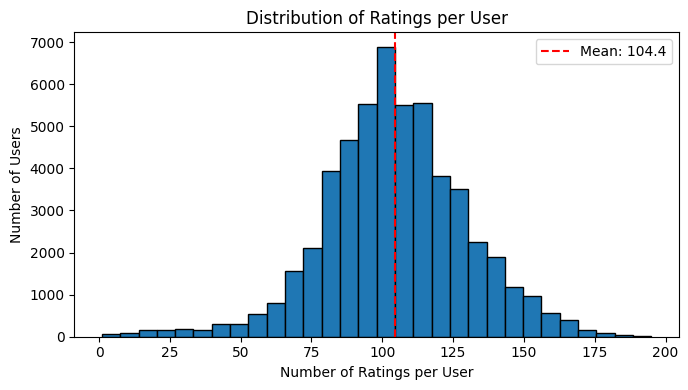

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.hist(user_activity, bins=30, edgecolor='black')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.axvline(user_activity.mean(), color='red', linestyle='--', label=f'Mean: {user_activity.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

To validate the numerical summary, we visualize how many books each user rated.  
The histogram above confirms that user engagement is evenly distributed, with most users rating between **80 and 120 books**.  
There are no extreme outliers, reinforcing the earlier conclusion that the dataset is well-balanced and suitable for collaborative filtering models.

#### **book_id**